In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import os

import numpy as np

from ipywidgets import interact, IntSlider
from colorama import Fore, Style
from statsmodels.graphics.tsaplots import plot_acf
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

from torch.utils.data import DataLoader
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

print(torch.__version__) 
print(torch.cuda.is_available())  
print(torch.cuda.get_device_name(0)) 


2.2.2+cu118
True
NVIDIA GeForce RTX 3060 Laptop GPU


---

#### Предварительно настроим стили графиков.

---

In [16]:
plt.style.use('https://raw.githubusercontent.com/dhaitz/matplotlib-stylesheets/master/pitayasmoothie-light.mplstyle')
# plt.style.use('https://raw.githubusercontent.com/dhaitz/matplotlib-stylesheets/master/pitayasmoothie-dark.mplstyle')

plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage[utf8]{inputenc}\usepackage[russian]{babel}',
    'axes.labelsize': 31, # названия осей 
    'xtick.labelsize': 26, # значения осей 
    'ytick.labelsize': 26, # значения осей
    'legend.fontsize': 22,  
    'axes.titlesize': 26,
})

---

#### Загрузим данные. И составим DataFrame.

---

In [17]:
df_data_2_years = pd.read_excel('input\\CHTETS4-Data-GT2-2022-2023-v2-18.08.2024.xlsx', sheet_name='Data', header = 10)

In [18]:
df_data_2_years = df_data_2_years.iloc[21:]

df_data_2_years.drop(columns="Unnamed: 0", inplace=True)
df_data_2_years.rename(columns={"SID": 'time'}, inplace=True)

In [19]:
df_data_2_years

,time,CHTEC4_TTO.12441,CHTEC4_TTO.12442,CHTEC4_TTO.12443,CHTEC4_TTO.12451,CHTEC4_TTO.12452,CHTEC4_TTO.12453,CHTEC4_TTO.12454,CHTEC4_TTO.12458,CHTEC4_TTO.12459,CHTEC4_TTO.12460,CHTEC4_TTO.12470,CHTEC4_TTO.12496,CHTEC4_TTO.12499,CHTEC4_TTO.22507,CHTEC4_TTO.22788,CHTEC4_TTO.22789,CHTEC4_TTO.22790,CHTEC4_TTO.22791
21,01.01.22 00:00,502.630018,14.727956,370.510894,73.537194,989.92813,-8.94626,981.705389,-5.770616,-7.038308,-5.355228,26.057132,1088.157471,92.764932,143.33443,4.903523,3.202395,15.250076,22.18531
22,01.01.22 01:00,502.297954,14.388092,370.558608,72.710003,989.452242,-8.714137,981.244018,-5.674671,-6.800248,-5.258674,26.01752,1088.157471,89.501112,144.345204,6.218756,3.265654,15.236482,21.96653
23,01.01.22 02:00,501.459262,14.4344,370.770397,73.678753,988.976354,-8.663222,980.782647,-5.578726,-6.562189,-5.162121,25.942435,1088.157471,89.911645,152.145919,6.73904,3.309285,15.122888,22.330646
24,01.01.22 03:00,500.62057,14.460314,370.982187,74.330347,988.499748,-8.778288,980.321276,-5.482781,-6.32413,-5.065567,25.956258,1088.157471,90.267643,143.503805,2.387159,3.133892,15.14222,22.306482
25,01.01.22 04:00,499.781878,14.486229,371.193976,74.178782,987.890632,-8.466152,979.865337,-5.386836,-6.124291,-4.969013,25.996714,1088.157471,90.510812,125.222104,1.059052,3.21163,14.983702,23.220673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17536,31.12.23 19:00,499.366265,14.893851,382.381074,87.914941,974.964563,-7.015762,963.382417,-3.231133,-4.259275,-2.673324,25.973933,1087.699707,95.274803,170.056588,4.470761,2.404646,16.731874,17.994607
17537,31.12.23 20:00,499.256774,14.877725,383.967367,89.716873,974.693103,-6.60099,962.884628,-1.698285,-2.933223,-1.033371,26.079173,1087.699707,96.224249,169.893957,4.628182,2.391174,16.703997,18.005851
17538,31.12.23 21:00,499.147282,14.839352,386.434564,91.524582,974.421643,-5.903147,962.386838,-0.20651,-1.815289,1.092264,25.991399,1087.699707,96.653807,169.731325,4.785602,2.377701,16.716452,17.892207
17539,31.12.23 22:00,499.037791,14.800978,388.854944,93.295846,974.150183,-5.024202,961.889048,1.181107,-0.568284,2.621017,26.000856,1087.699707,97.031287,169.568694,4.943023,2.364229,16.701704,17.868458


<!DOCTYPE html>
<html lang="ru">
<head>
<hr>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <title>Проверка данных</title>
  <style>
    body {
      font-family: Arial, sans-serif;
      text-align: center;
      margin: 50px;
    }
    .title-container {
      display: flex;
      justify-content: center;
      align-items: center;
    }
    .title {
      font-size: 34px;
      font-weight: bold;
      text-align: center;
      margin-bottom: 1px; 
    }
    .steps-row {
      display: flex;
      justify-content: center;
      align-items: center;
      gap: 50px;
    }
    .step-container {
      display: flex;
      flex-direction: column;
      align-items: center;
    }
    .arrow {
      font-size: 50px;
      color: gray;
      margin-bottom: 20px; 
      margin-top: 20px; 
    }
    .arrow:first-of-type {
      margin-left: 700px;
    }
    .step {
      background: #007bff;
      color: white;
      font-weight: bold;
      padding: 15px 10px; 
      border-radius: 20px;
      font-size: 18px;
      text-align: center;
      width: auto;
    }
  </style>
</head>
<body>
  <div class="title-container">
    <div class="title">Видно, что данные записывались каждый час - используем это, проверив:</div>
  </div>
  <div class="steps-row">
    <div class="step-container">
      <div class="arrow">↙</div>
      <div class="step">1. Количество записей в данных соответствуют 2 годам.</div>
    </div>
    <div class="step-container">
      <div class="arrow">↘</div>
      <div class="step">2. Нет дубликатов по времени.</div>
    </div>
  </div>
  <hr>
</body>
</html>




In [20]:
def check_time_pass(data: pd.DataFrame) -> None:
    """
    Проверяет временные данные на наличие пропусков и дубликатов.

    Функция выполняет две проверки:
    1. Проверяет, что количество уникальных временных меток (time) == двум полным годам (24 часа * 365 дней * 2);
    2. Проверяет, что количество уникальных временных меток (time) == количеству строк в данных (data) (отсутствие дубликатов);

    Параметры:
    data (pd.DataFrame): Датафрейм с колонкой 'time', содержащей временные метки. (Например df_data_2_years).

    Исключения:
    ValueError: Прерывается работа скрипта, если обнаружены временные пропуски или дубликаты.

    Возвращает: None.
    """
    if data.time.nunique() / 24 / 365 != 2:
        raise ValueError(f"{Fore.LIGHTRED_EX}🚨 Есть временные пропуски{Style.RESET_ALL}")
    
    if data.time.nunique() != data.shape[0]:
        raise ValueError(f"{Fore.LIGHTRED_EX}🚨 Есть дубликаты по времени{Style.RESET_ALL}")
    
    print(f"{Fore.LIGHTGREEN_EX}✅ OK{Style.RESET_ALL} | В данных все хорошо! Нет пропусков по времени и дубликатов.")

    

check_time_pass(df_data_2_years)

✅ OK | В данных все хорошо! Нет пропусков по времени и дубликатов.


In [21]:
def check_missing_values(data: pd.DataFrame) -> None:
    """
    Провряет наличие пропущенных значений в датафрейме.

    Функция выводит количество пропусков в каждом столбце.  
    Если пропуски есть, выводит предупреждение.  
    Если пропусков нет, сообщает, что всё в порядке.

    Параметры:
    data (pd.DataFrame): Датафрейм для проверки (например df_data_2_years).

    Возвращает: None.
    """
    missing = data.isna().sum()
    missing = missing[missing > 0]

    if not missing.empty:
        message = f"🚨 {Fore.LIGHTRED_EX}Найдены пропуски:\n{Style.RESET_ALL}" + "\n".join(f"{col}: {count}" for col, count in missing.items())
        raise ValueError(f"{message}")
    
    print(f"{Fore.LIGHTGREEN_EX}✅ OK{Style.RESET_ALL} | Пропусков нет!")



check_missing_values(df_data_2_years)

✅ OK | Пропусков нет!


In [22]:
df_data_2_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 21 to 17540
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   time              17520 non-null  object
 1   CHTEC4_TTO.12441  17520 non-null  object
 2   CHTEC4_TTO.12442  17520 non-null  object
 3   CHTEC4_TTO.12443  17520 non-null  object
 4   CHTEC4_TTO.12451  17520 non-null  object
 5   CHTEC4_TTO.12452  17520 non-null  object
 6   CHTEC4_TTO.12453  17520 non-null  object
 7   CHTEC4_TTO.12454  17520 non-null  object
 8   CHTEC4_TTO.12458  17520 non-null  object
 9   CHTEC4_TTO.12459  17520 non-null  object
 10  CHTEC4_TTO.12460  17520 non-null  object
 11  CHTEC4_TTO.12470  17520 non-null  object
 12  CHTEC4_TTO.12496  17520 non-null  object
 13  CHTEC4_TTO.12499  17520 non-null  object
 14  CHTEC4_TTO.22507  17520 non-null  object
 15  CHTEC4_TTO.22788  17520 non-null  object
 16  CHTEC4_TTO.22789  17520 non-null  object
 17  CHTEC4_TTO.

---

#### Поменяем тип данных.

---

In [23]:
df_data_2_years['time'] = pd.to_datetime(df_data_2_years['time'])

columns_to_convert = df_data_2_years.columns.difference(['time'])
df_data_2_years[columns_to_convert] = df_data_2_years[columns_to_convert].astype(float)

C:\Users\ilya\AppData\Local\Temp\ipykernel_18616\293447735.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_data_2_years['time'] = pd.to_datetime(df_data_2_years['time'])


---

Проверки пройдены, можем нарисовать графики.

---

In [24]:
df_data_2_years.sort_values(by = 'time', inplace = True)

In [ ]:
start_index = 0
palette = sns.color_palette("Spectral", n_colors=start_index+50)
palette = palette[::-1]
colors = palette[start_index:] + palette[:start_index]

time_column = 'time'
columns_to_plot = df_data_2_years.columns[1:]



for i, column in enumerate(columns_to_plot):
    plt.figure(figsize=(22, 8))
    # plt.subplot(len(columns_to_plot) // 3 + 1, 3, i + 1) 
    plt.plot(df_data_2_years[time_column], df_data_2_years[column], label=column, color = colors[i])
    # plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.title(f'{column}')
    plt.xticks(rotation=45) 

    # plt.suptitle('Графики для каждой метрики', fontsize=36)
    plt.tight_layout()  
    plt.subplots_adjust(top=0.9)  
    plt.show()


---

#### Видно, что есть выбросы и сезонность. 

---

---

# Метеорологический Датасет

---

Загрузим метеоданные по географической локации Челябинская ТЭЦ-4 за 2022-2023 года с кратностью в 1 час:

- latitude = 55.204716
- longitude = 61.407467

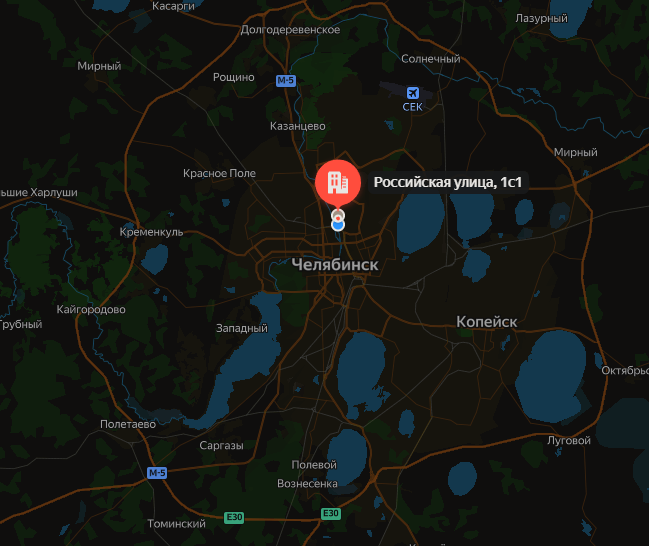
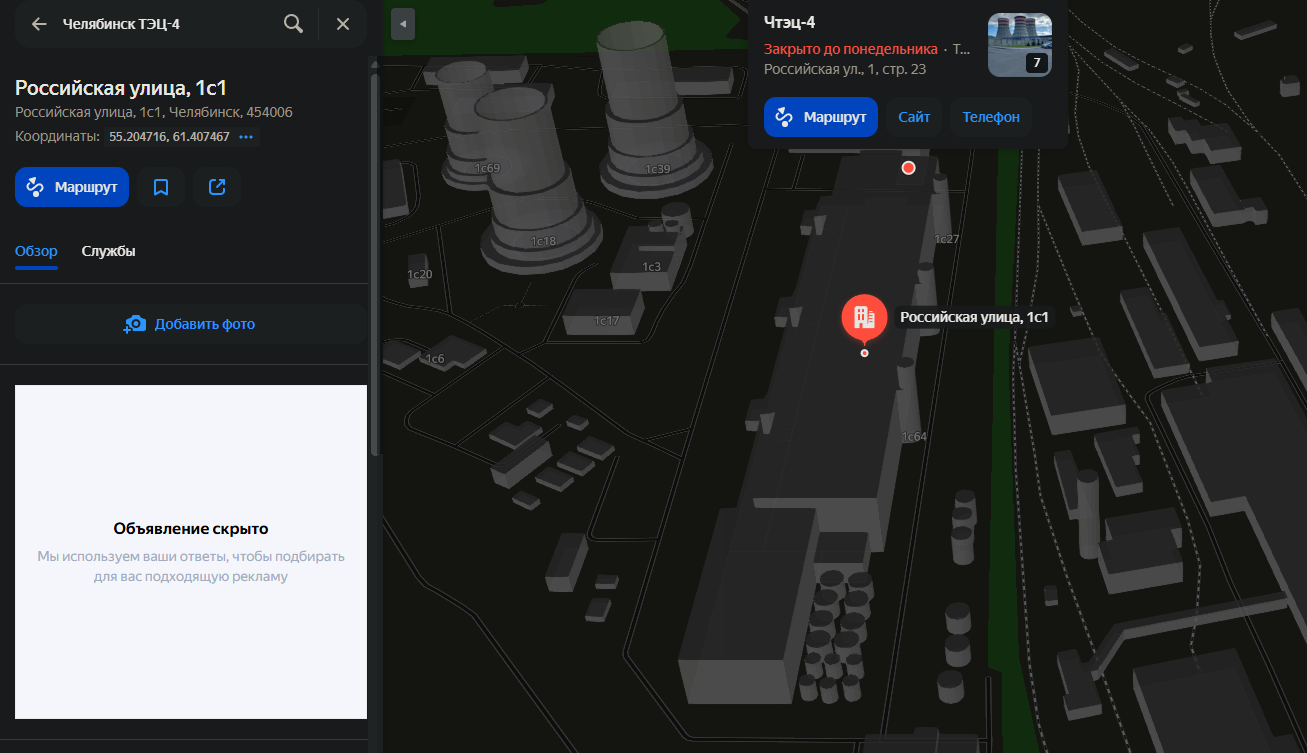

In [26]:
try:
    df = pd.read_csv('chelyabinsk_tecz4_weather.csv')
except:
    # Координаты Челябинской ТЭЦ-4
    latitude = 55.204716
    longitude = 61.407467

    # URL архивного API
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": "cloudcover,relative_humidity_2m,precipitation,pressure_msl,temperature_2m,wind_speed_10m,wind_direction_10m",
        "start_date": "2022-01-01",
        "end_date": "2023-12-31",
        "timezone": "Europe/Moscow"
    }

    response = requests.get(url, params=params)
    data = response.json()

    df = pd.DataFrame({
        "time": data["hourly"]["time"],
        "cloud_cover": data["hourly"]["cloudcover"],
        "humidity": data["hourly"]["relative_humidity_2m"],
        "precipitation": data["hourly"]["precipitation"],
        "pressure": data["hourly"]["pressure_msl"],
        "temperature": data["hourly"]["temperature_2m"],
        "wind_speed": data["hourly"]["wind_speed_10m"],
        "wind_direction": data["hourly"]["wind_direction_10m"]
    })

    df.to_csv("chelyabinsk_tecz4_weather.csv", index=False)

    print("Исторические данные успешно загружены и сохранены в chelyabinsk_tecz4_weather.csv")


---

#### Проверим данные.

---

In [27]:
check_time_pass(df)
check_missing_values(df)

✅ OK | В данных все хорошо! Нет пропусков по времени и дубликатов.
✅ OK | Пропусков нет!


In [28]:
df

,time,cloud_cover,humidity,precipitation,pressure,temperature,wind_speed,wind_direction
0,2022-01-01T00:00,91,82,0.0,1020.7,-10.5,12.2,194
1,2022-01-01T01:00,98,81,0.0,1020.0,-10.8,13.9,190
2,2022-01-01T02:00,99,80,0.0,1019.6,-11.4,15.4,191
3,2022-01-01T03:00,40,78,0.0,1018.9,-10.6,17.6,195
4,2022-01-01T04:00,99,79,0.0,1018.1,-11.3,17.4,193
...,...,...,...,...,...,...,...,...
17515,2023-12-31T19:00,100,94,0.2,1005.4,-6.1,16.9,164
17516,2023-12-31T20:00,100,95,0.7,1004.3,-3.7,17.7,168
17517,2023-12-31T21:00,100,94,0.8,1002.9,-1.3,21.1,172
17518,2023-12-31T22:00,100,93,0.2,1002.1,-0.3,24.5,182


---

Посмотрим тип данных.

---

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            17520 non-null  object 
 1   cloud_cover     17520 non-null  int64  
 2   humidity        17520 non-null  int64  
 3   precipitation   17520 non-null  float64
 4   pressure        17520 non-null  float64
 5   temperature     17520 non-null  float64
 6   wind_speed      17520 non-null  float64
 7   wind_direction  17520 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.1+ MB


In [30]:
df['time'] = pd.to_datetime(df['time'])

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time            17520 non-null  datetime64[ns]
 1   cloud_cover     17520 non-null  int64         
 2   humidity        17520 non-null  int64         
 3   precipitation   17520 non-null  float64       
 4   pressure        17520 non-null  float64       
 5   temperature     17520 non-null  float64       
 6   wind_speed      17520 non-null  float64       
 7   wind_direction  17520 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 1.1 MB


In [32]:
df.head(3)

,time,cloud_cover,humidity,precipitation,pressure,temperature,wind_speed,wind_direction
0,2022-01-01 00:00:00,91,82,0.0,1020.7,-10.5,12.2,194
1,2022-01-01 01:00:00,98,81,0.0,1020.0,-10.8,13.9,190
2,2022-01-01 02:00:00,99,80,0.0,1019.6,-11.4,15.4,191



---

## Характеристики данных

- **Количество записей:** 17520  
- **Количество признаков:** 8  
- **Пропущенные значения:** Отсутствуют 

---

## Структура данных

|**Название столбца**       | **Описание**                                                                                      | **Тип данных** |
|----------------------------|---------------------------------------------------------------------------------------------------|----------------|
| `time`                    | Временная метка (yyyy-mm-dd hh-mm-ss) записи данных                                                | `datetime64[ns]`|
| `cloud_cover`             | Облачность, %. Показывает долю неба, покрытую облаками                                           | `int64`        |
| `humidity`                | Относительная влажность воздуха, %                                                              | `int64`        |
| `precipitation`           | Количество осадков за час, мм                                                    | `float64`      |
| `pressure`                | Атмосферное давление, гПа                                                           | `float64`      |
| `temperature`             | Температура воздуха, °C                                                    | `float64`      |
| `wind_speed`              | Скорость воздушного потока                   | `float64`      |
| `wind_direction`          | Направление ветра     | `int64`        |


---

---

## Статистика по данным

In [33]:
df.describe()

,time,cloud_cover,humidity,precipitation,pressure,temperature,wind_speed,wind_direction
count,17520,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000
mean,2022-12-31 23:30:00,64.316381,70.043607,0.057443,1017.432745,4.281330,12.757323,211.724201
min,2022-01-01 00:00:00,0.000000,8.000000,0.000000,978.400000,-38.200000,0.000000,1.000000
25%,2022-07-02 11:45:00,17.000000,58.000000,0.000000,1009.600000,-6.000000,8.700000,160.000000
50%,2022-12-31 23:30:00,93.000000,75.000000,0.000000,1017.200000,5.200000,12.100000,223.000000
75%,2023-07-02 11:15:00,100.000000,84.000000,0.000000,1024.200000,15.100000,16.200000,290.000000
max,2023-12-31 23:00:00,100.000000,100.000000,8.900000,1063.100000,38.300000,40.400000,360.000000
std,NaN,41.427219,18.731398,0.298223,11.625777,13.419786,5.511396,95.641902


----


### Построим графики

---

In [34]:
dict_description = {
    "time": {
        "description": "Временная метка",
        "data_type": "datetime64[ns]"
    },
    "cloud_cover": {
        "description": "Облачность",
        "data_type": "int64"
    },
    "humidity": {
        "description": "Относительная влажность воздуха",
        "data_type": "int64"
    },
    "precipitation": {
        "description": "Количество осадков за час, мм",
        "data_type": "float64"
    },
    "pressure": {
        "description": "Атмосферное давление, гПа",
        "data_type": "float64"
    },
    "temperature": {
        "description": "Температура воздуха, °C",
        "data_type": "float64"
    },
    "wind_speed": {
        "description": "Скорость воздушного потока",
        "data_type": "float64"
    },
    "wind_direction": {
        "description": "Направление ветра",
        "data_type": "int64"
    }
}

In [ ]:
start_index = 0
palette = sns.color_palette("Spectral", n_colors=start_index+20)
palette = palette[::-1]
colors = palette[start_index:] + palette[:start_index]

time_column = 'time'
columns_to_plot = df.columns[1:]



for i, column in enumerate(columns_to_plot):
    plt.figure(figsize=(22, 8))
    # plt.subplot(len(columns_to_plot) // 3 + 1, 3, i + 1) 
    plt.plot(df[time_column], df[column], label=column, color = colors[i])
    # plt.xlabel('Время')
    plt.ylabel('Значение')
    print(dict_description[column]['description'])
    plt.title(dict_description[column]['description'])
    plt.xticks(rotation=45) 

    # plt.suptitle('Графики для каждой метрики', fontsize=36)
    plt.tight_layout()  
    plt.subplots_adjust(top=0.9)  
    plt.show()


----

Построим агрегированные (по дням, неделям, месяцам) графики:


In [ ]:
start_index = 0
palette = sns.color_palette("Spectral", n_colors=start_index + 40)
palette = palette[::-1]
colors = palette[start_index:] + palette[:start_index]

time_column = 'time'
metrics_to_aggregate = df.columns[1:]

df_daily = df.resample('D', on=time_column).mean()
df_weekly = df.resample('W', on=time_column).mean()
df_monthly = df.resample('M', on=time_column).mean()

# Построение графиков
plt.figure(figsize=(22, len(metrics_to_aggregate) * 6))

for i, metric in enumerate(metrics_to_aggregate):
    plt.subplot(len(metrics_to_aggregate), 1, i + 1)

    plt.plot(df_daily.index, df_daily[metric], label='Daily', color=colors[i], linestyle='-', linewidth=2)
    plt.plot(df_weekly.index, df_weekly[metric], label='Weekly', color=colors[i + 6], linestyle='--', linewidth=5)
    plt.plot(df_monthly.index, df_monthly[metric], label='Monthly', color=colors[i + 10], linewidth=6)
    
    plt.title(f'{dict_description[metric]["description"]}', fontsize=14)
    plt.ylabel('Значение')
    # plt.xlabel('Время')
    plt.xticks(rotation=45)
    plt.legend(loc='upper right') 

plt.suptitle('Агрегированные данные: дни, недели, месяцы', fontsize=36)

plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Отображение графиков
plt.show()

In [41]:
start_index = 0
palette = sns.color_palette("Spectral", n_colors=start_index+50)
palette = palette[::-1]
colors = palette[start_index:] + palette[:start_index]

C:\Users\ilya\AppData\Local\Temp\ipykernel_18616\1102710995.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_data_2_years.resample('M', on=time_column).mean()


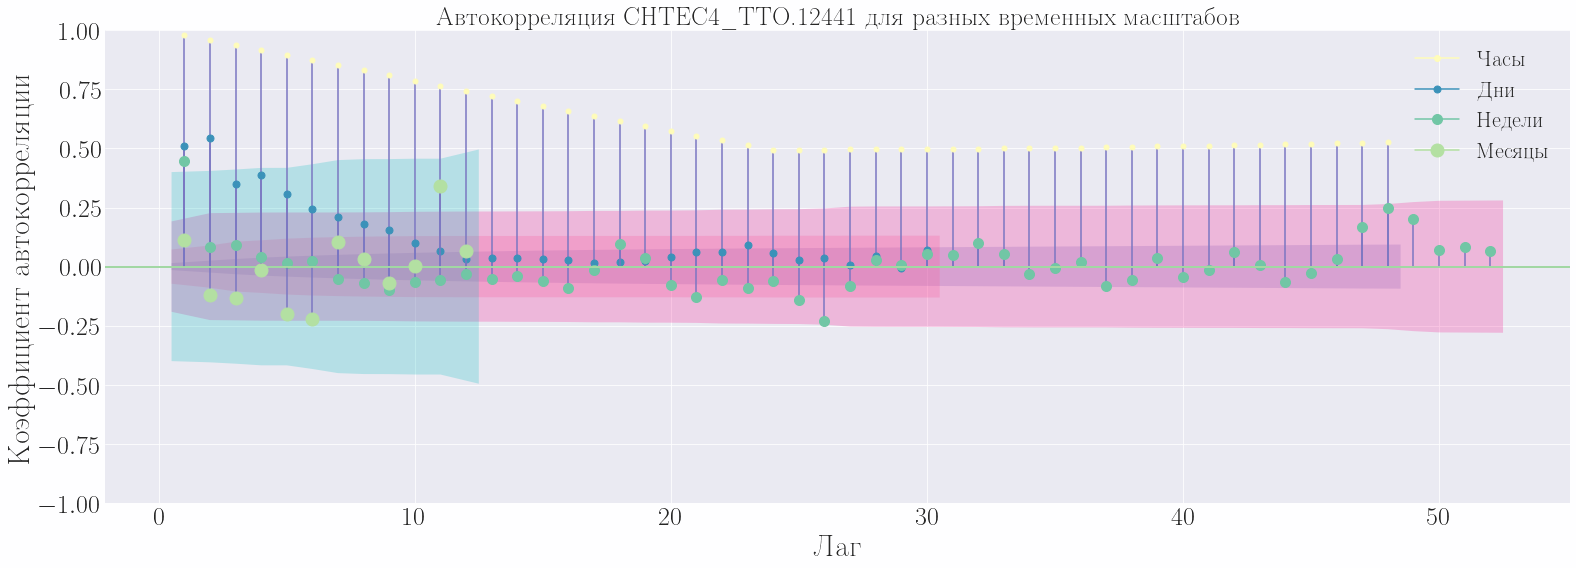

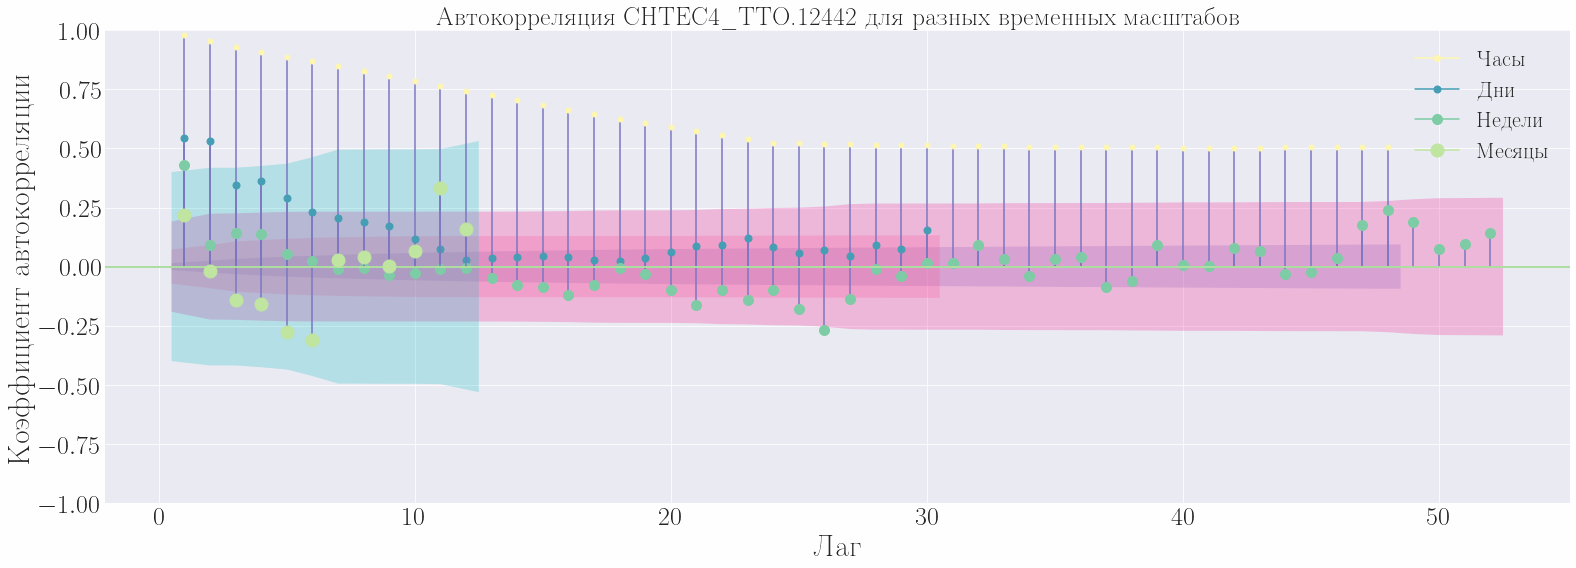

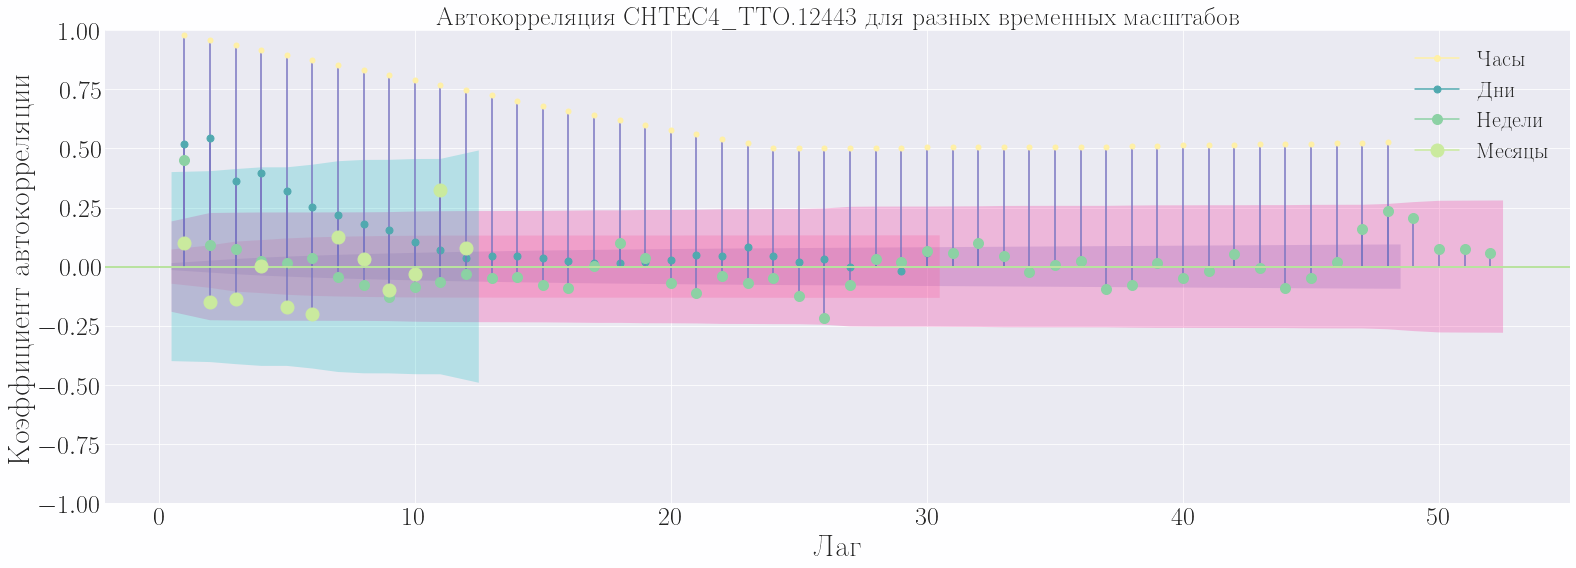

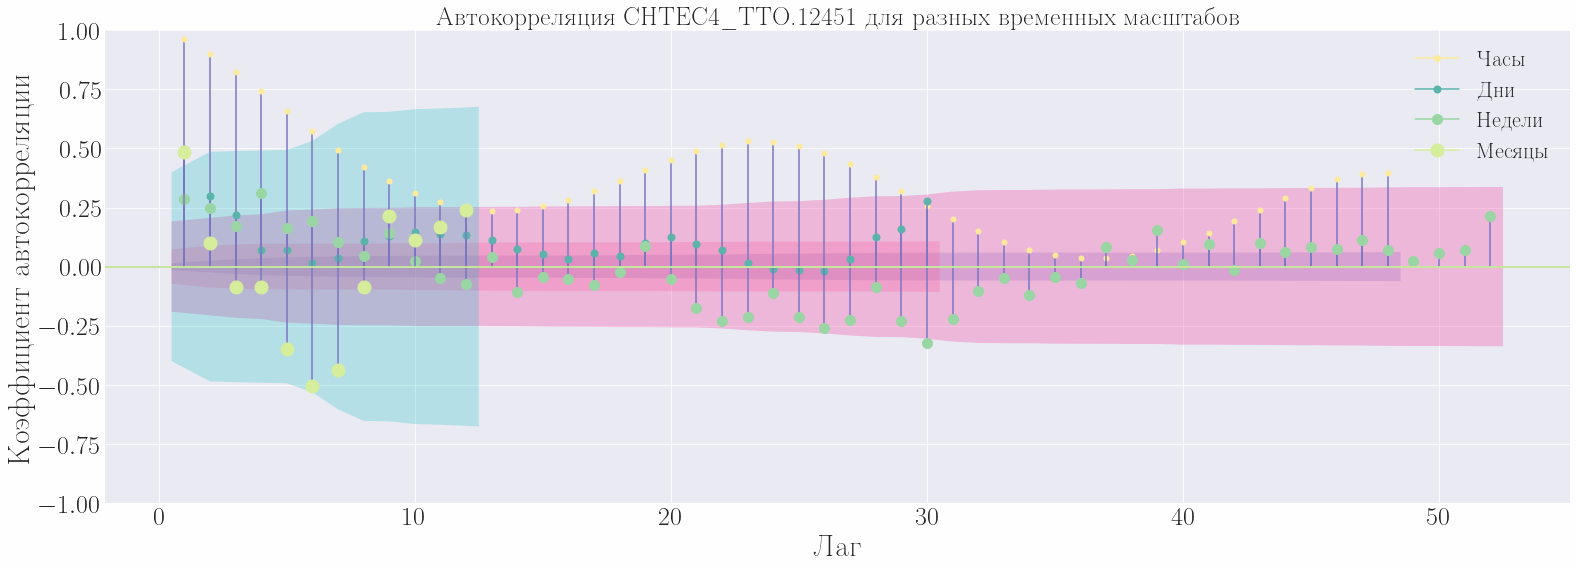

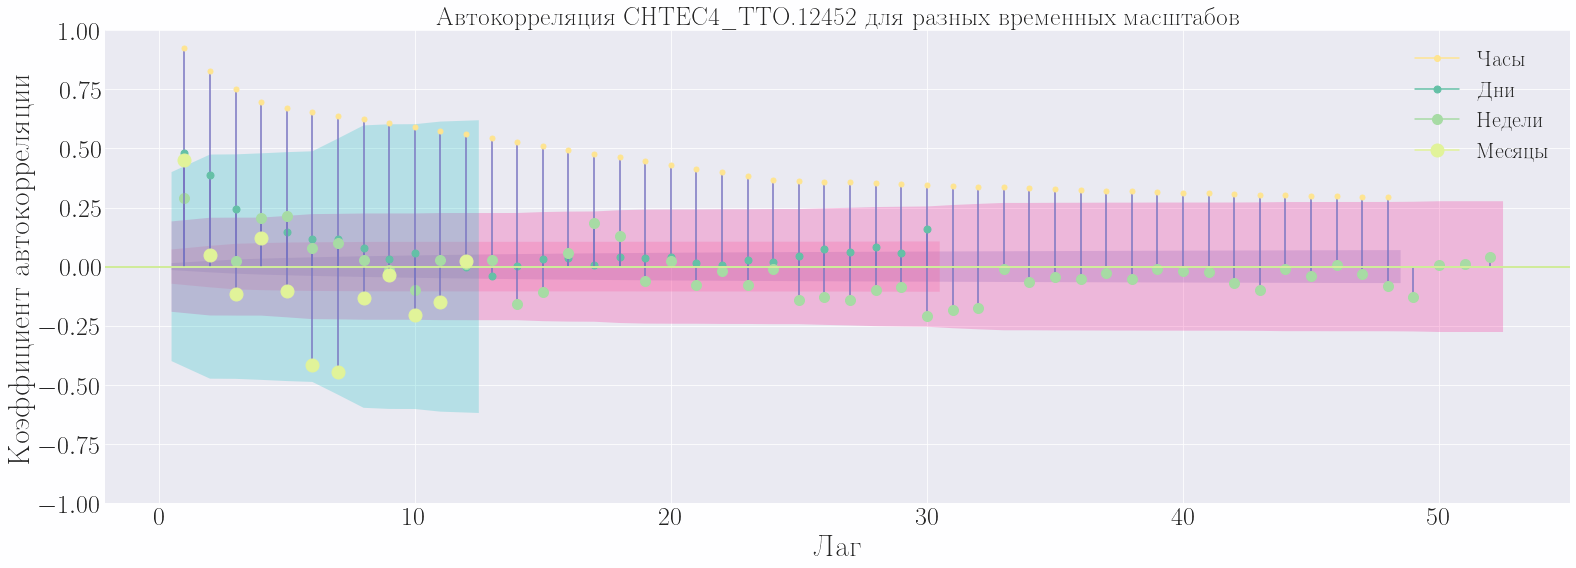

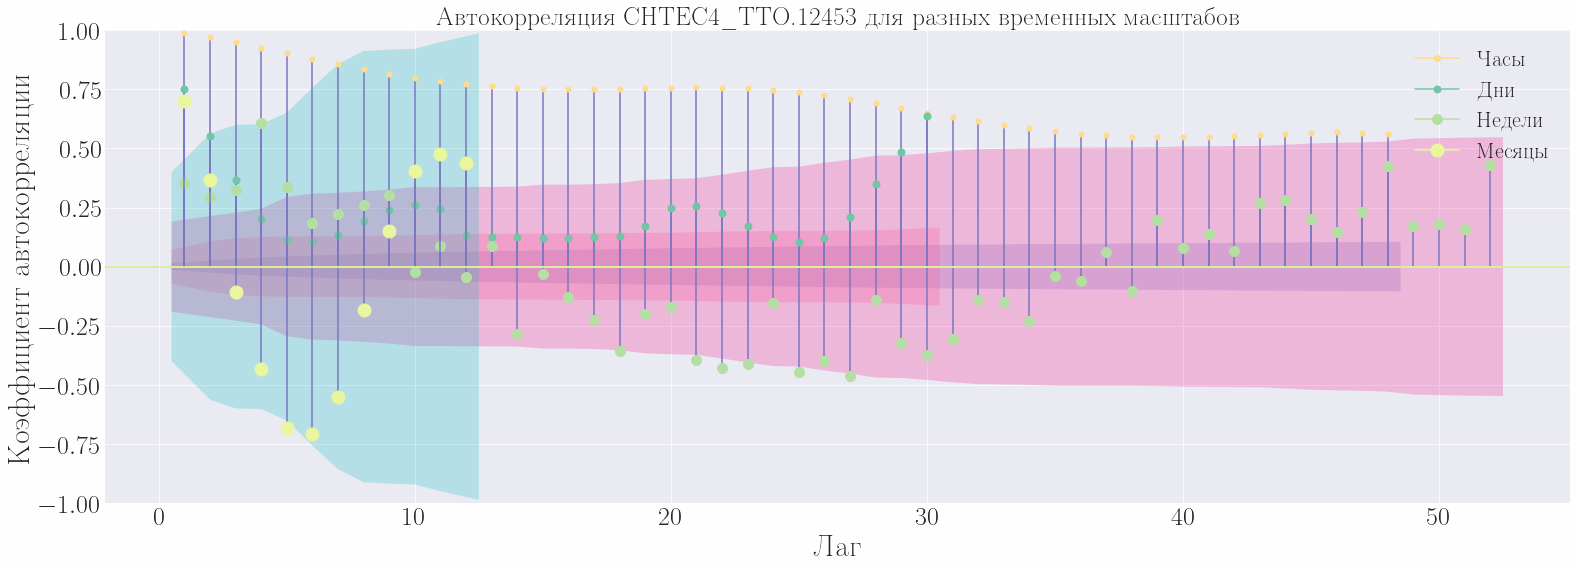

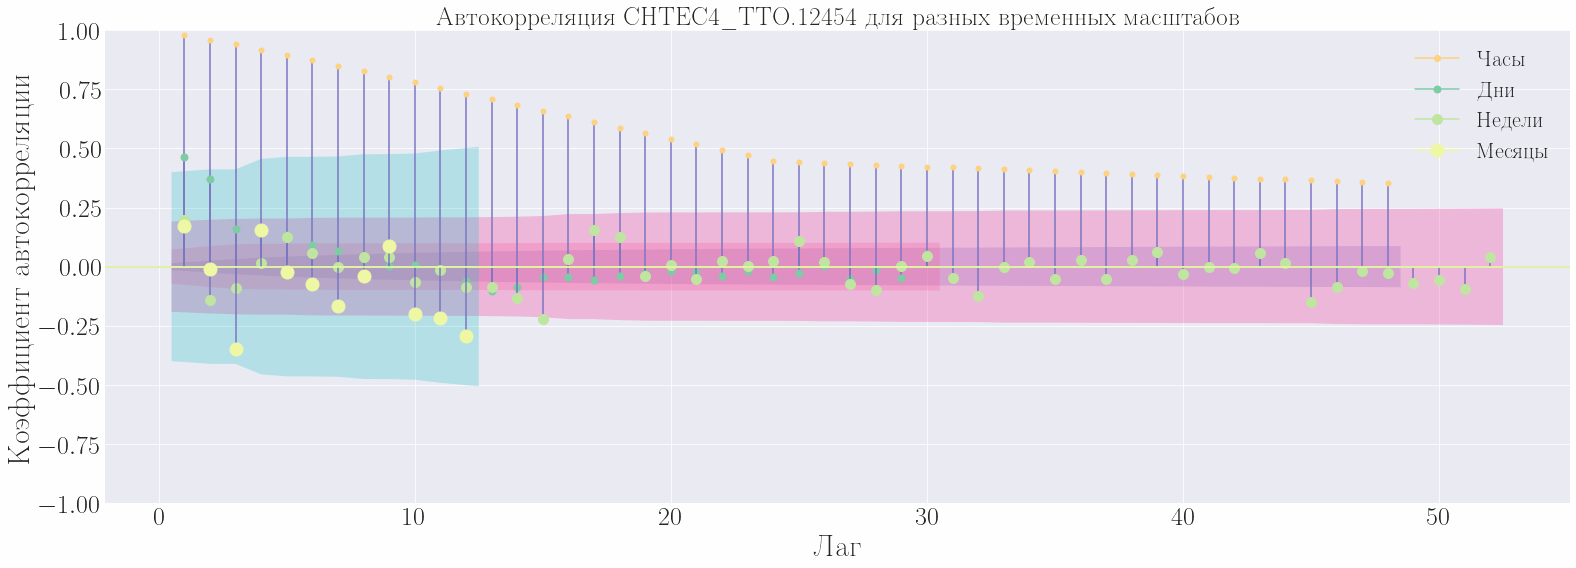

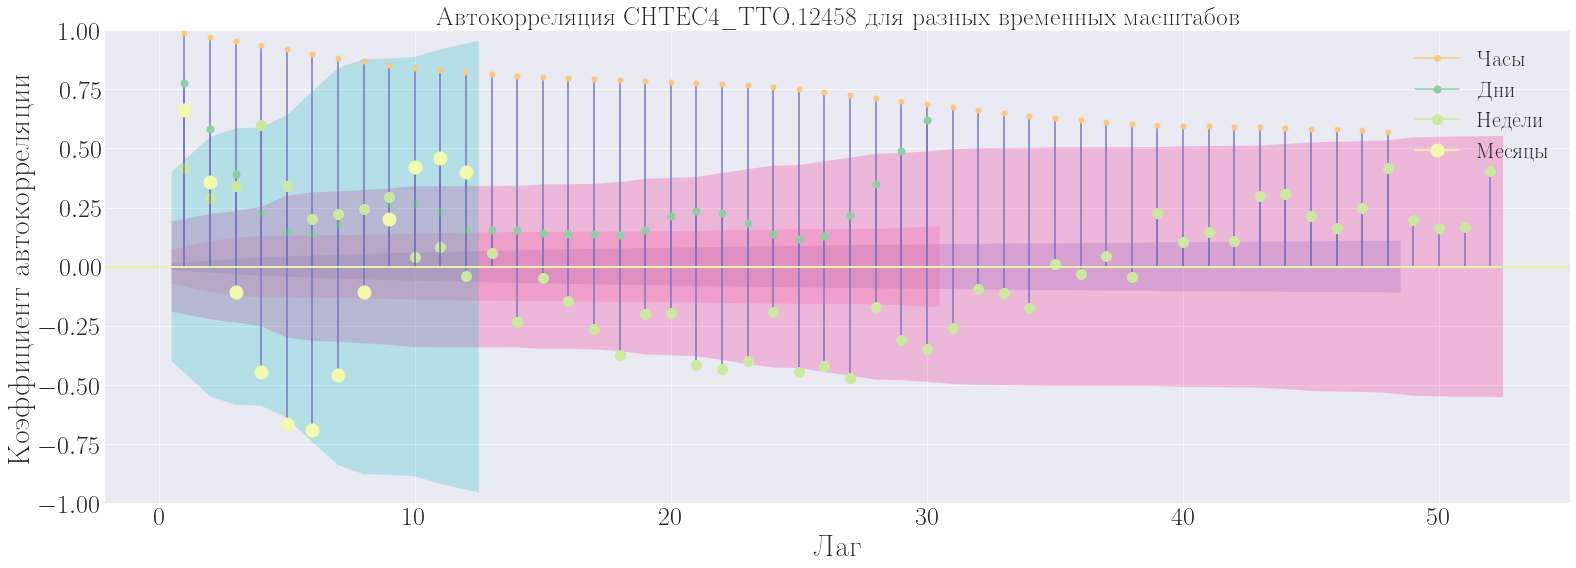

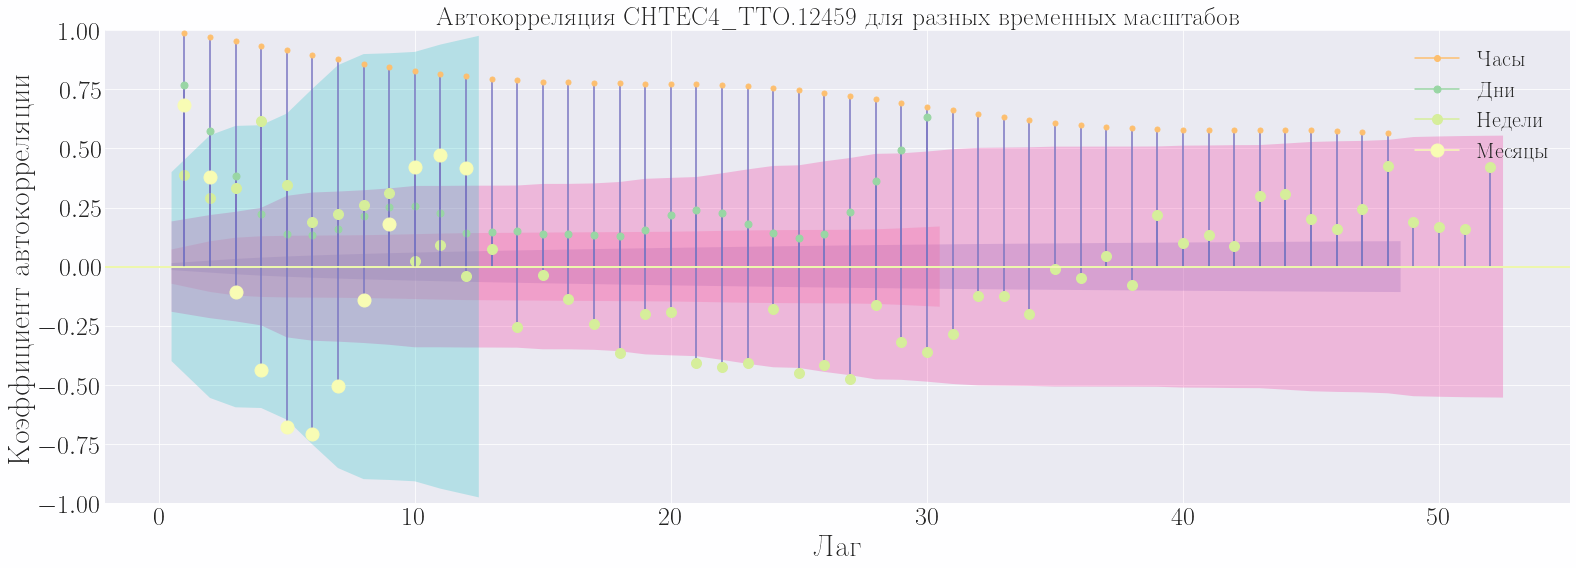

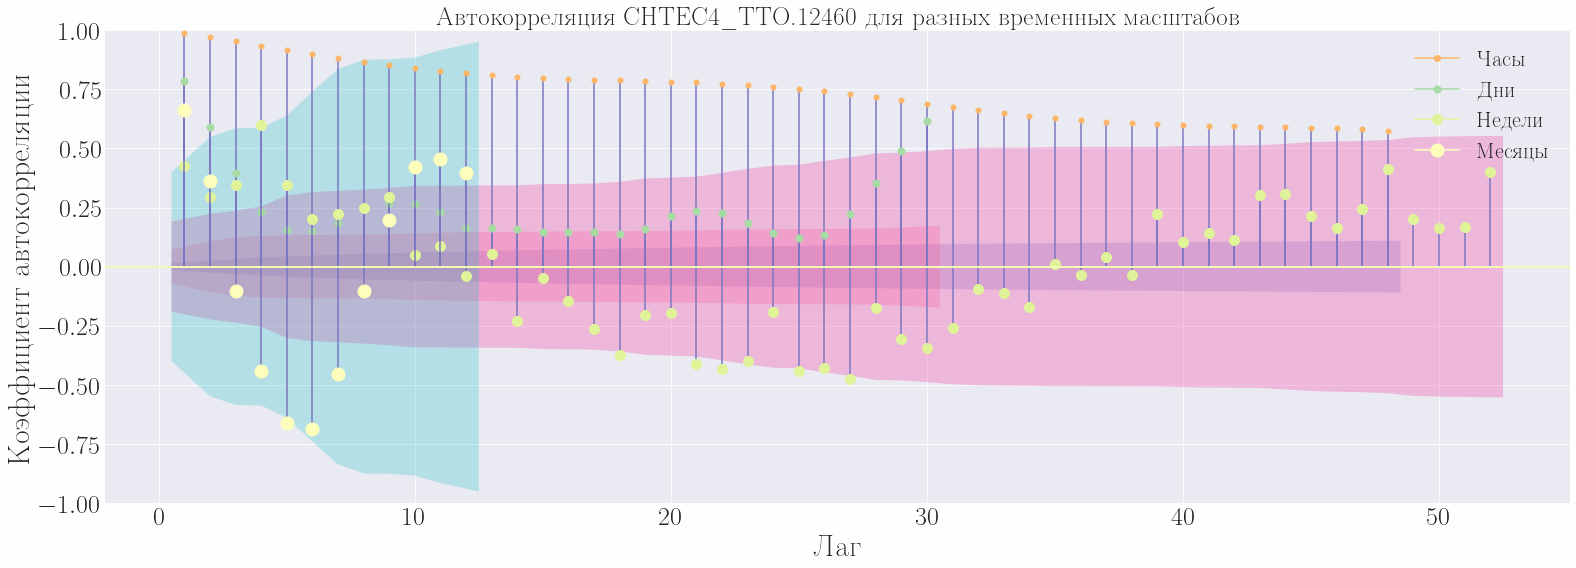

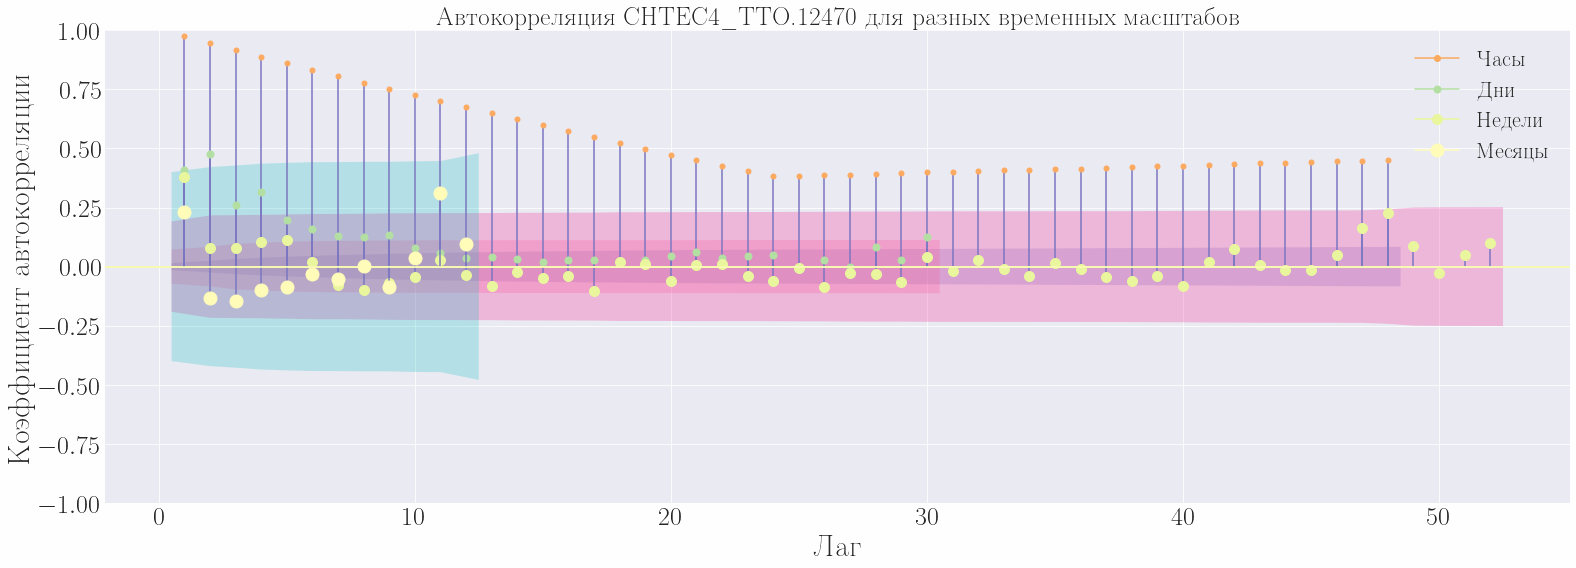

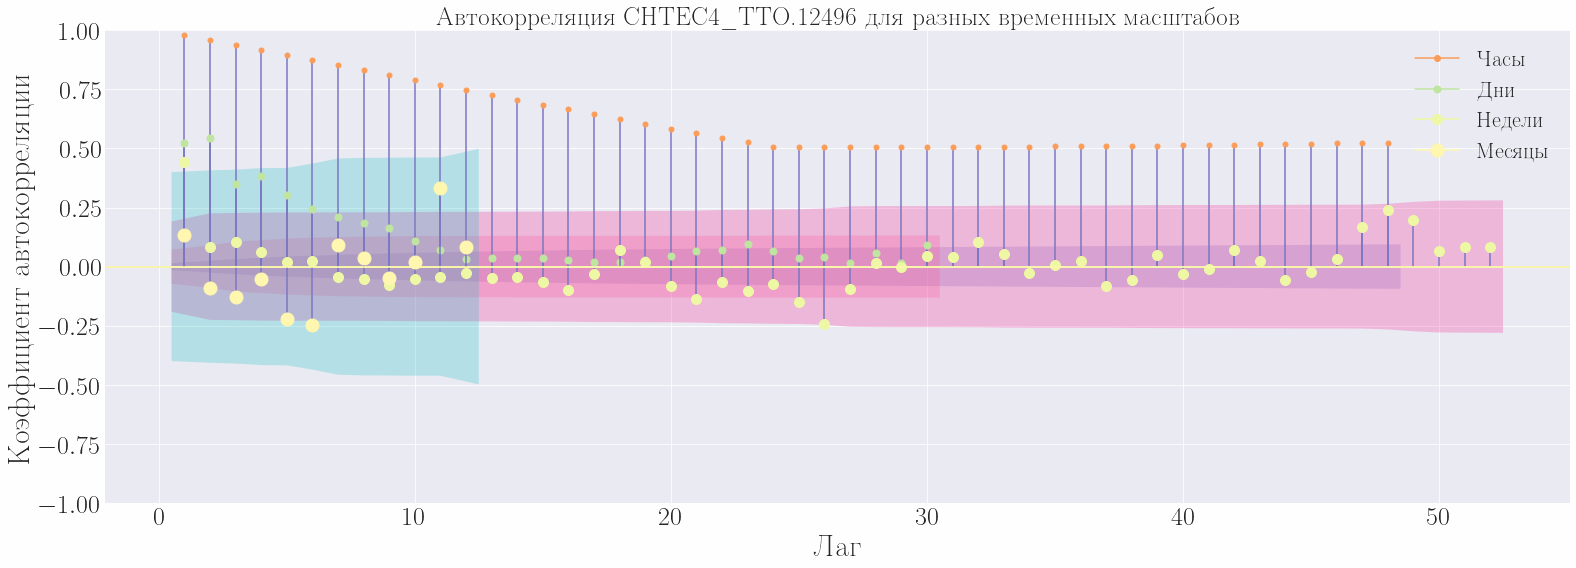

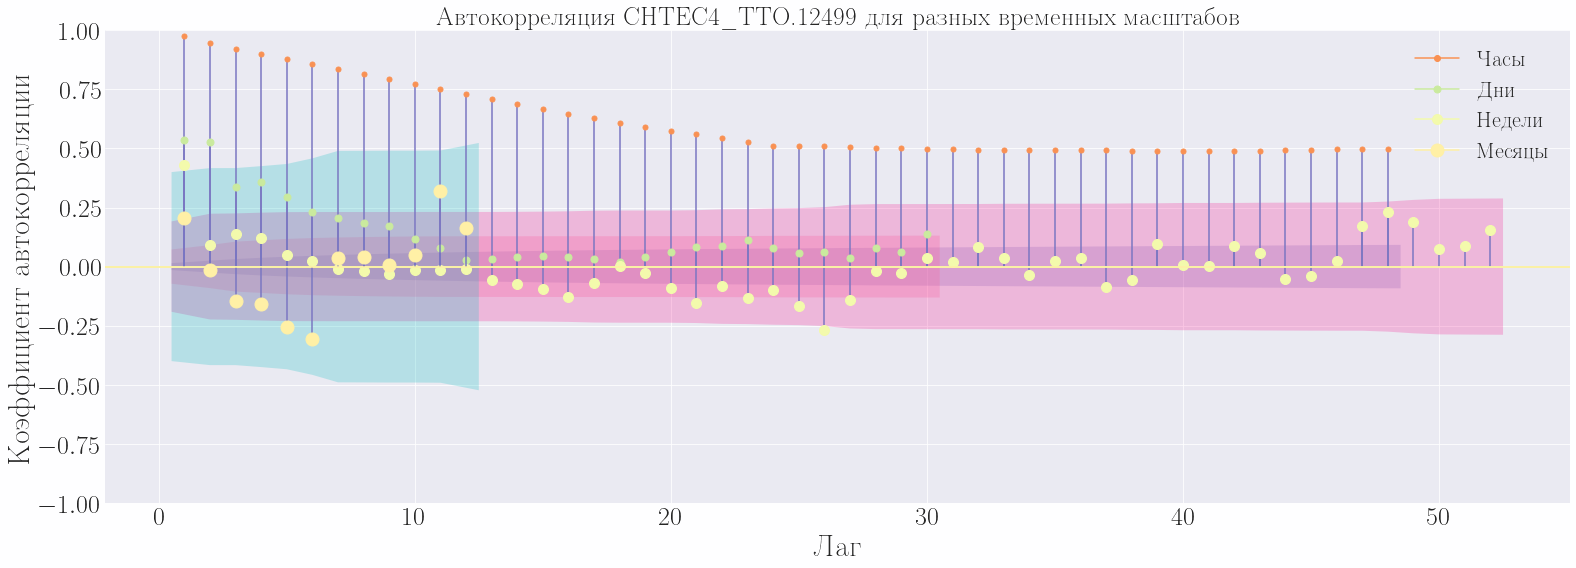

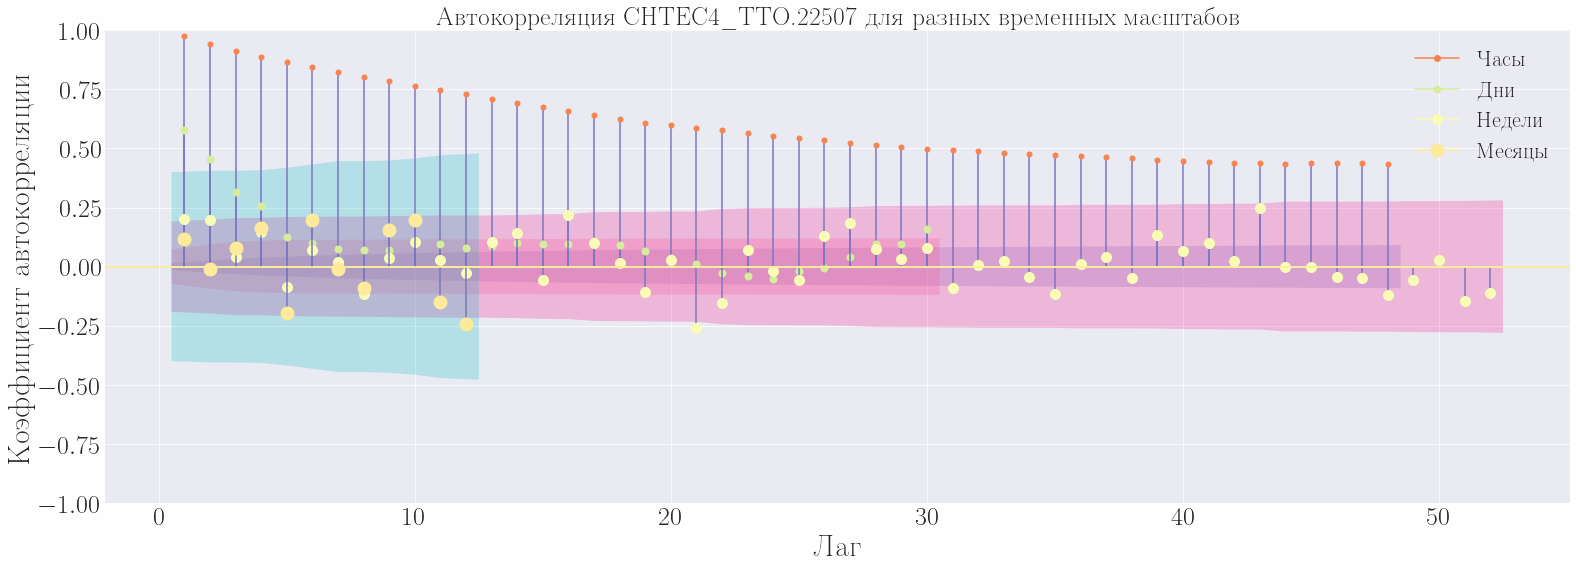

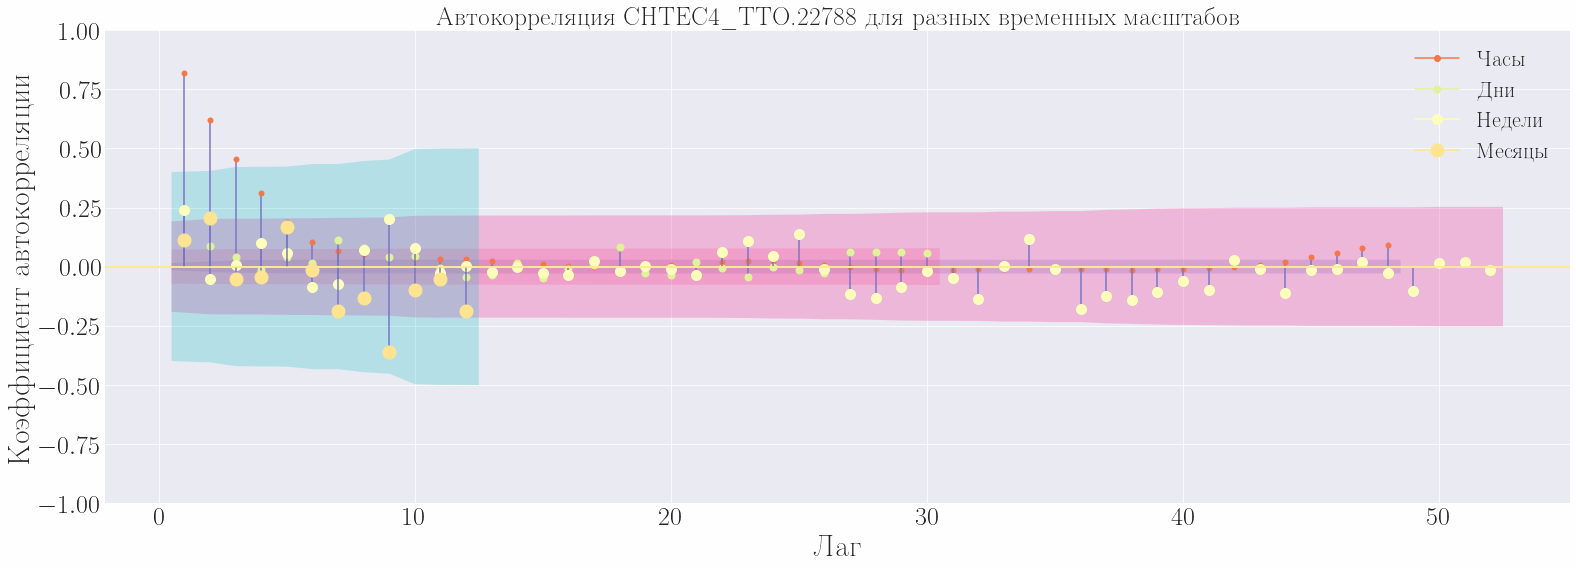

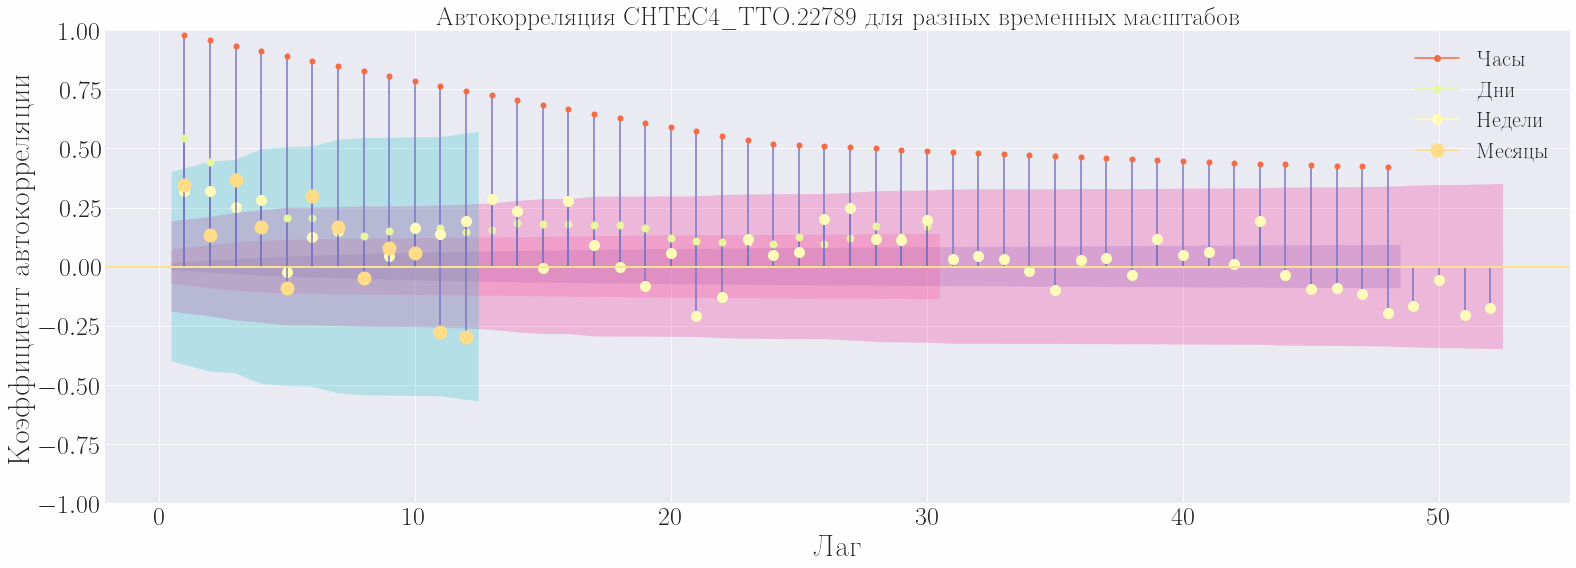

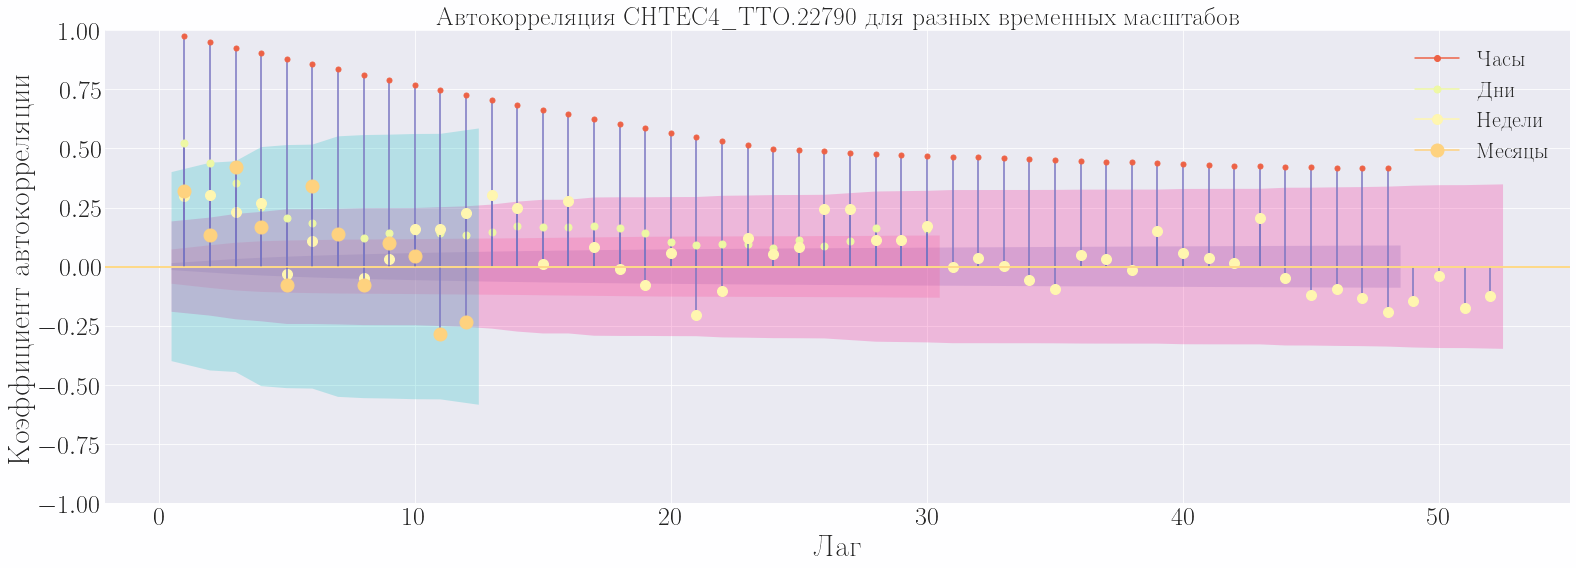

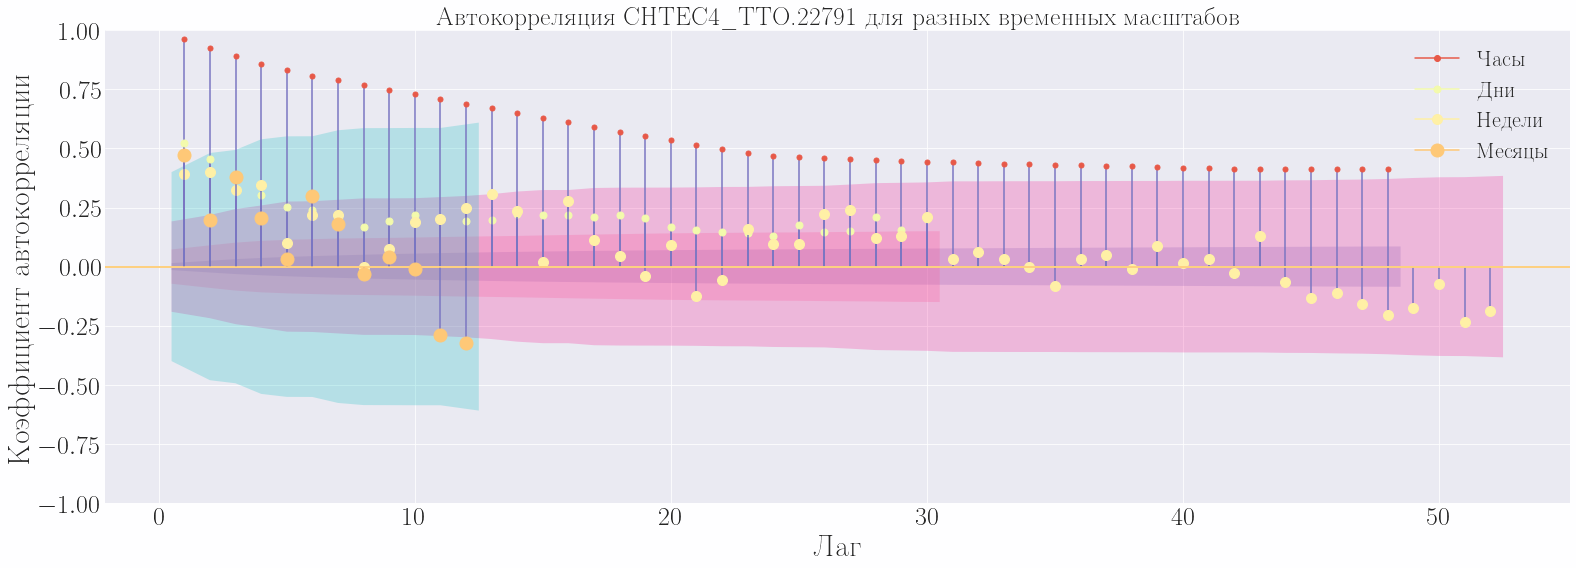

In [43]:
metrics_to_analyze = df_data_2_years.columns[1:]

df_hourly = df_data_2_years
df_daily = df_data_2_years.resample('D', on=time_column).mean()
df_weekly = df_data_2_years.resample('W', on=time_column).mean()
df_monthly = df_data_2_years.resample('M', on=time_column).mean()

for i, metric in enumerate(metrics_to_analyze):
    # Создаем новую фигуру для каждой метрики
    plt.figure(figsize=(22, 8))
    
    # Создаем оси для текущего графика
    ax = plt.gca()
    
    # Рисуем все ACF на одних осях
    plot_acf(df_hourly[metric], lags=48, alpha=0.05, color=colors[i+25], title="", ax=ax, zero=False, label='Часы')
    
    plot_acf(df_daily[metric], lags=30, alpha=0.05, color=colors[i+5], title="", ax=ax, zero=False, label='Дни')
    for line in ax.lines:
        if line.get_color() == colors[i+5]:  
            line.set_markersize(7)  
            line.set_markerfacecolor(colors[i+5])
    
    plot_acf(df_weekly[metric], lags=52, alpha=0.05, color=colors[i+10], title="", ax=ax, zero=False, label='Недели')
    for line in ax.lines:
        if line.get_color() == colors[i+10]:  
            line.set_markersize(10)  
            line.set_markerfacecolor(colors[i+10])
    
    plot_acf(df_monthly[metric], lags=12, alpha=0.05, color=colors[i+15], title="", ax=ax, zero=False, label='Месяцы')
    for line in ax.lines:
        if line.get_color() == colors[i+15]:  
            line.set_markersize(13)  
            line.set_markerfacecolor(colors[i+15])
    
    # Настраиваем легенду
    legend_elements = [
        plt.Line2D([0], [0], color=colors[i+25], marker='o', label='Часы'),
        plt.Line2D([0], [0], color=colors[i+5], marker='o', markersize=7, label='Дни'),
        plt.Line2D([0], [0], color=colors[i+10], marker='o', markersize=10, label='Недели'),
        plt.Line2D([0], [0], color=colors[i+15], marker='o', markersize=13, label='Месяцы')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right')
    

    ax.set_title(f'Автокорреляция {metric} для разных временных масштабов')
    ax.set_ylabel('Коэффициент автокорреляции')
    ax.set_xlabel('Лаг')
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

---

### Видно, что у всех графиков кроме скорости ветра и направления ветра есть сезонность.

##### Построим график автокорреляции (Pearson Autocorrelation). 

Автокорреляция — это мера корреляции между значениями временного ряда и его же значениями в предыдущие моменты времени (отставания, lags). Она помогает определить, насколько текущее значение зависит от прошлых значений.



---

In [ ]:
metrics_to_analyze = df.columns[1:]

df_hourly = df
df_daily = df.resample('D', on=time_column).mean()
df_weekly = df.resample('W', on=time_column).mean()
df_monthly = df.resample('M', on=time_column).mean()

for i, metric in enumerate(metrics_to_analyze):
    # Создаем новую фигуру для каждой метрики
    plt.figure(figsize=(22, 8))
    
    # Создаем оси для текущего графика
    ax = plt.gca()
    
    # Рисуем все ACF на одних осях
    plot_acf(df_hourly[metric], lags=48, alpha=0.05, color=colors[i], title="", ax=ax, zero=False, label='Часы')
    
    plot_acf(df_daily[metric], lags=30, alpha=0.05, color=colors[i+5], title="", ax=ax, zero=False, label='Дни')
    for line in ax.lines:
        if line.get_color() == colors[i+5]:  
            line.set_markersize(7)  
            line.set_markerfacecolor(colors[i+5])
    
    plot_acf(df_weekly[metric], lags=52, alpha=0.05, color=colors[i+10], title="", ax=ax, zero=False, label='Недели')
    for line in ax.lines:
        if line.get_color() == colors[i+10]:  
            line.set_markersize(10)  
            line.set_markerfacecolor(colors[i+10])
    
    plot_acf(df_monthly[metric], lags=12, alpha=0.05, color=colors[i+15], title="", ax=ax, zero=False, label='Месяцы')
    for line in ax.lines:
        if line.get_color() == colors[i+15]:  
            line.set_markersize(13)  
            line.set_markerfacecolor(colors[i+15])
    
    # Настраиваем легенду
    legend_elements = [
        plt.Line2D([0], [0], color=colors[i], marker='o', label='Часы'),
        plt.Line2D([0], [0], color=colors[i+5], marker='o', markersize=7, label='Дни'),
        plt.Line2D([0], [0], color=colors[i+10], marker='o', markersize=10, label='Недели'),
        plt.Line2D([0], [0], color=colors[i+15], marker='o', markersize=13, label='Месяцы')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right')
    
    # Заголовок и подписи
    metric_name = dict_description[metric]["description"]
    ax.set_title(f'Автокорреляция {metric_name} для разных временных масштабов')
    ax.set_ylabel('Коэффициент автокорреляции')
    ax.set_xlabel('Лаг')
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

### Видно, что:
- #### Годовую сезонность имеет (исходя из недельной и месячной автокорреляции):
    - Облачность 
    - Относительная влажность воздуха
    - Количество осадков (слабая)
    - Атмосферное давление (слабая)
    - Скорость воздушного потока (слабая)
    - Температура воздуха

- #### Дневная зависимость:
    - Облачность 
    - Относительная влажность воздуха
    - Количество осадков (слабая)
    - Атмосферное давление
    - Температура воздуха
    - Скорость воздушного потока (слабая)

- #### Часовая зависимость - у всех имеется.

---

Существует статистический критерий Льюнга-Бокса, который математически ответит на вопрос о значимости отклонения.

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

time_column = 'time'
metrics_to_analyze = df.columns[1:]

df_hourly = df  
df_daily = df.resample('D', on=time_column).mean()
df_weekly = df.resample('W', on=time_column).mean()
df_monthly = df.resample('M', on=time_column).mean()

significance_level = 0.05

results = {}

for metric in metrics_to_analyze:
    results[metric] = {}
    
    # Часы
    lb_test_hourly = acorr_ljungbox(df_hourly[metric], lags=48, return_df=True)
    results[metric]['hourly'] = lb_test_hourly
    
    # Дни
    lb_test_daily = acorr_ljungbox(df_daily[metric], lags=30, return_df=True)
    results[metric]['daily'] = lb_test_daily
    
    # Недели
    lb_test_weekly = acorr_ljungbox(df_weekly[metric], lags=52, return_df=True)
    results[metric]['weekly'] = lb_test_weekly
    
    # Месяцы
    lb_test_monthly = acorr_ljungbox(df_monthly[metric], lags=12, return_df=True)
    results[metric]['monthly'] = lb_test_monthly

for metric, scales in results.items():
    print(f"Результаты для {dict_description[metric]['description']}:")
    for scale, result in scales.items():
        print(f"  - {scale.capitalize()}:")
        print("     Lags   |   Statistic   |   P-value")
        for _, row in result.iterrows():
            lag = int(row['lb_stat'])
            statistic = round(row['lb_pvalue'], 4)
            p_value = round(row['lb_pvalue'], 4)
            significant = f"{Fore.LIGHTGREEN_EX}Значимо{Style.RESET_ALL}" if p_value < significance_level else f"{Fore.LIGHTRED_EX}Не значимо{Style.RESET_ALL}"
            print(f"     {lag:<6} |   {statistic:<12} |   {p_value:<8} |   {significant}")

---

#### Как видно, есть срезы, в которых ответ меняется в зависимости от lag. Например: Облачность - Monthly.

Чтобы не просматривать все глазами - посмтроим табличку, где для каждой метрики и каждого временного масштаба (часы, дни, недели, месяцы) будет указано только одно значение — "Значимо" или "Не значимо" (в зависимости от того, есть ли хотя бы одно значимое значение в результатах теста Льюнга-Бокса)

---

In [ ]:
significance_level = 0.05

compact_results = {}

for metric, scales in results.items():
    compact_results[metric] = {}
    for scale, result in scales.items():
        is_significant = any(row['lb_pvalue'] < significance_level for _, row in result.iterrows())
        compact_results[metric][scale] = is_significant

print(f"{'Метрика':<32} | {'Часы':<7} | {'Дни':<11} | {'Недели':<11} | {'Месяцы':<10}")
print("-" * 80)

for metric, scales in compact_results.items():
    metric_name = dict_description[metric]['description']
    hourly = f"{Fore.LIGHTGREEN_EX}Значимо{Style.RESET_ALL}" if scales['hourly'] else f"{Fore.LIGHTRED_EX}Не значимо{Style.RESET_ALL}"
    daily = f"{Fore.LIGHTGREEN_EX}Значимо{Style.RESET_ALL}" if scales['daily'] else f"{Fore.LIGHTRED_EX}Не значимо{Style.RESET_ALL}"
    weekly = f"{Fore.LIGHTGREEN_EX}Значимо{Style.RESET_ALL}" if scales['weekly'] else f"{Fore.LIGHTRED_EX}Не значимо{Style.RESET_ALL}"
    monthly = f"{Fore.LIGHTGREEN_EX}Значимо{Style.RESET_ALL}" if scales['monthly'] else f"{Fore.LIGHTRED_EX}Не значимо{Style.RESET_ALL}"
    
    print(f"{metric_name:<32} | {hourly:<10} | {daily:<20} | {weekly:<20} | {monthly:<20}")

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

time_column = 'time'
metrics_to_analyze = df_data_2_years.columns[1:]

df_hourly = df_data_2_years
df_daily = df_data_2_years.resample('D', on=time_column).mean()
df_weekly = df_data_2_years.resample('W', on=time_column).mean()
df_monthly = df_data_2_years.resample('M', on=time_column).mean()

significance_level = 0.05

results = {}

for metric in metrics_to_analyze:
    results[metric] = {}
    
    # Часы
    lb_test_hourly = acorr_ljungbox(df_hourly[metric], lags=48, return_df=True)
    results[metric]['hourly'] = lb_test_hourly
    
    # Дни
    lb_test_daily = acorr_ljungbox(df_daily[metric], lags=30, return_df=True)
    results[metric]['daily'] = lb_test_daily
    
    # Недели
    lb_test_weekly = acorr_ljungbox(df_weekly[metric], lags=52, return_df=True)
    results[metric]['weekly'] = lb_test_weekly
    
    # Месяцы
    lb_test_monthly = acorr_ljungbox(df_monthly[metric], lags=12, return_df=True)
    results[metric]['monthly'] = lb_test_monthly

significance_level = 0.05

compact_results = {}

for metric, scales in results.items():
    compact_results[metric] = {}
    for scale, result in scales.items():
        is_significant = any(row['lb_pvalue'] < significance_level for _, row in result.iterrows())
        compact_results[metric][scale] = is_significant

print(f"{'Метрика':<32} | {'Часы':<7} | {'Дни':<11} | {'Недели':<11} | {'Месяцы':<10}")
print("-" * 80)

for metric, scales in compact_results.items():
    metric_name = metric
    hourly = f"{Fore.LIGHTGREEN_EX}Значимо{Style.RESET_ALL}" if scales['hourly'] else f"{Fore.LIGHTRED_EX}Не значимо{Style.RESET_ALL}"
    daily = f"{Fore.LIGHTGREEN_EX}Значимо{Style.RESET_ALL}" if scales['daily'] else f"{Fore.LIGHTRED_EX}Не значимо{Style.RESET_ALL}"
    weekly = f"{Fore.LIGHTGREEN_EX}Значимо{Style.RESET_ALL}" if scales['weekly'] else f"{Fore.LIGHTRED_EX}Не значимо{Style.RESET_ALL}"
    monthly = f"{Fore.LIGHTGREEN_EX}Значимо{Style.RESET_ALL}" if scales['monthly'] else f"{Fore.LIGHTRED_EX}Не значимо{Style.RESET_ALL}"
    
    print(f"{metric_name:<32} | {hourly:<10} | {daily:<20} | {weekly:<20} | {monthly:<20}")

In [ ]:
df_merge = pd.merge(df_data_2_years, df, on='time')

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Вычисляем матрицу корреляций
# corr_matrix = df_merge.corr()


In [ ]:
# Создаем тепловую карту с увеличенными значениями и выделением столбцов
plt.figure(figsize=(16, 12))

highlight_cols = ['CHTEC4_TTO.22791', 'CHTEC4_TTO.22789']


heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1, vmax=1,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={
        "shrink": 1,  # Уменьшаем размер шкалы (по умолчанию 0.8)
        "aspect": 20,    # Контролирует пропорции шкалы
        "pad": 0.01      # Отступ от основного графика
    },
    annot_kws={"size": 13},
    alpha=0.9
)

plt.yticks(
    ticks=np.arange(len(corr_matrix)) + 0.5,  # Центрируем подписи
    labels=corr_matrix.index,
    fontsize=10,
    rotation=0  # Убираем наклон для Y
)

# Добавляем рамки вокруг выделенных столбцов
for i, col in enumerate(corr_matrix.columns):
    if col in highlight_cols:
        heatmap.add_patch(plt.Rectangle((i, 0), 1, len(corr_matrix), 
                                      fill=False, edgecolor='blue', lw=2, linestyle=':'))
        
for j, row in enumerate(corr_matrix.index):
    if row in highlight_cols:
        heatmap.add_patch(plt.Rectangle(
            (0, j), len(corr_matrix.columns), 1,
            fill=False,
            edgecolor='blue',
            lw=1,
            linestyle='--'
        ))

plt.title('Матрица корреляций признаков', pad=20, fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
df_merge['CHTEC4_TTO.22789']

0        3.202395
1        3.265654
2        3.309285
3        3.133892
4        3.211630
           ...   
17515    2.404646
17516    2.391174
17517    2.377701
17518    2.364229
17519    2.350756
Name: CHTEC4_TTO.22789, Length: 17520, dtype: float64

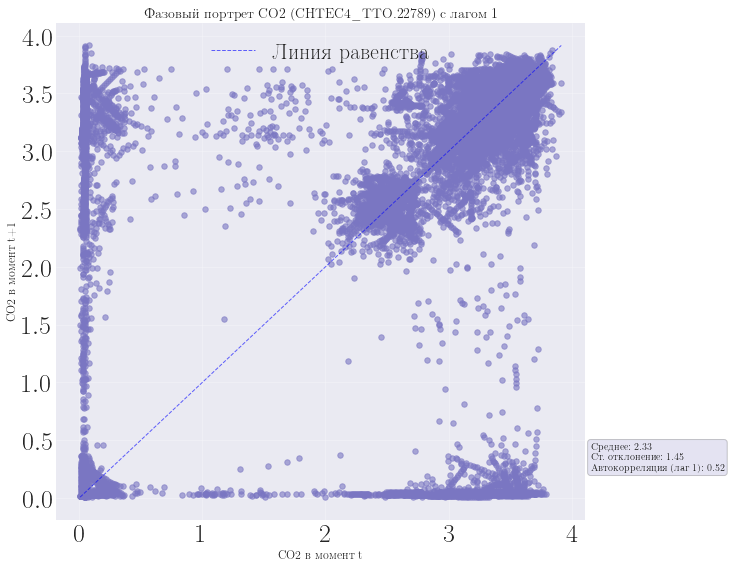

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot

# Извлекаем данные по CO2
co2_series = df_merge['CHTEC4_TTO.22789'].dropna()

# Создаем фигуру
plt.figure(figsize=(10, 8))

# Строим фазовый портрет с лагом 1
lag_plot(co2_series, lag=24, alpha=0.6, s=30)

# Добавляем диагональ для визуальной оценки
x = np.linspace(co2_series.min(), co2_series.max(), 100)
plt.plot(x, x, 'b--', lw=1, label='Линия равенства', alpha=0.6)

plt.title('Фазовый портрет CO2 (CHTEC4_TTO.22789) с лагом 1', fontsize=14)
plt.xlabel('CO2 в момент t', fontsize=12)
plt.ylabel('CO2 в момент t+1', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Добавляем статистическую информацию в аннотацию
stats_text = (f"Среднее: {co2_series.mean():.2f}\n"
              f"Ст. отклонение: {co2_series.std():.2f}\n"
              f"Автокорреляция (лаг 1): {co2_series.autocorr(lag=24):.2f}")
plt.annotate(stats_text, xy=(1.01, 0.1), xycoords='axes fraction', 
             bbox=dict(boxstyle='round', alpha=0.2))

plt.tight_layout()
plt.show()

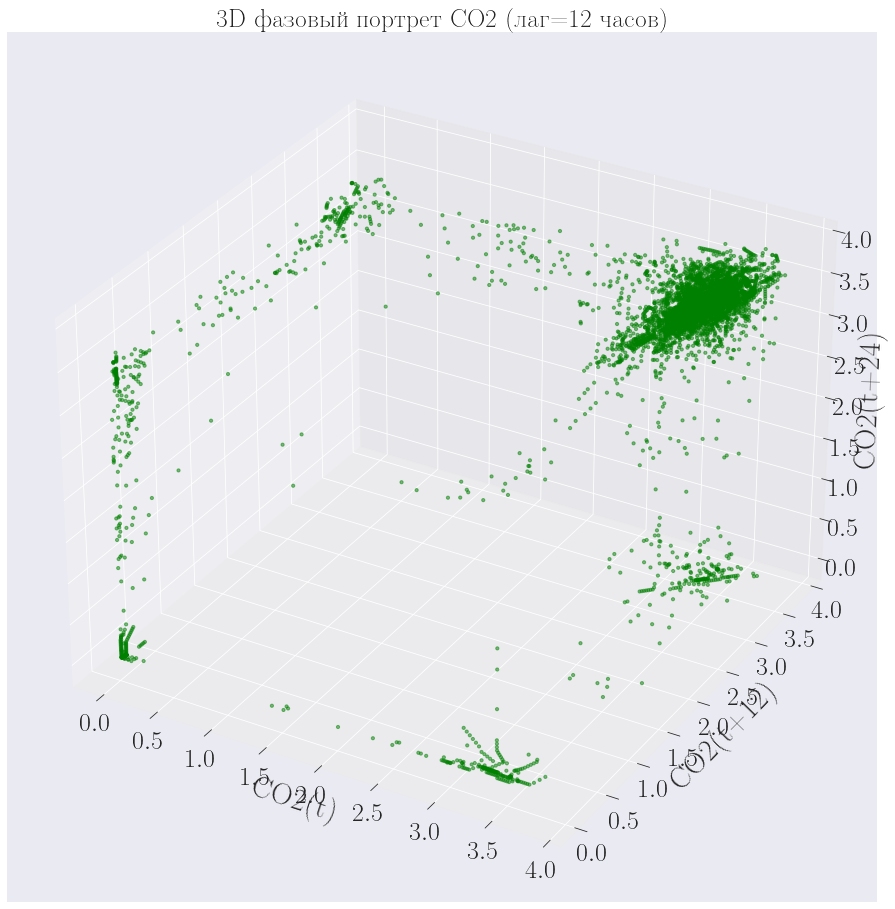

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Строим 3D фазовый портрет по трем последовательным точкам
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111, projection='3d')

lags = 12  # Суточный цикл для ТЭЦ
points = 5000  # Ограничим количество точек для наглядности

x = co2_series.iloc[:points]
y = co2_series.shift(-lags).iloc[:points]
z = co2_series.shift(-2*lags).iloc[:points]

ax.scatter(x, y, z, c='g', alpha=0.5, s=10)
ax.set_title(f'3D фазовый портрет CO2 (лаг={lags} часов)')
ax.set_xlabel('CO2(t)')
ax.set_ylabel(f'CO2(t+{lags})')
ax.set_zlabel(f'CO2(t+{2*lags})')

plt.show()

In [ ]:
co2_series = df_merge['CHTEC4_TTO.22789'].dropna()

In [ ]:
def takens_embedding(series, m, lag):
    n = len(series) - (m - 1) * lag
    return np.array([series.iloc[i: i + m * lag: lag].values for i in range(n)])

m = 48
lag = 12 
embedded = takens_embedding(co2_series, m, lag)
print("Форма вектора фазового пространства:", embedded.shape)


Форма вектора фазового пространства: (16956, 48)


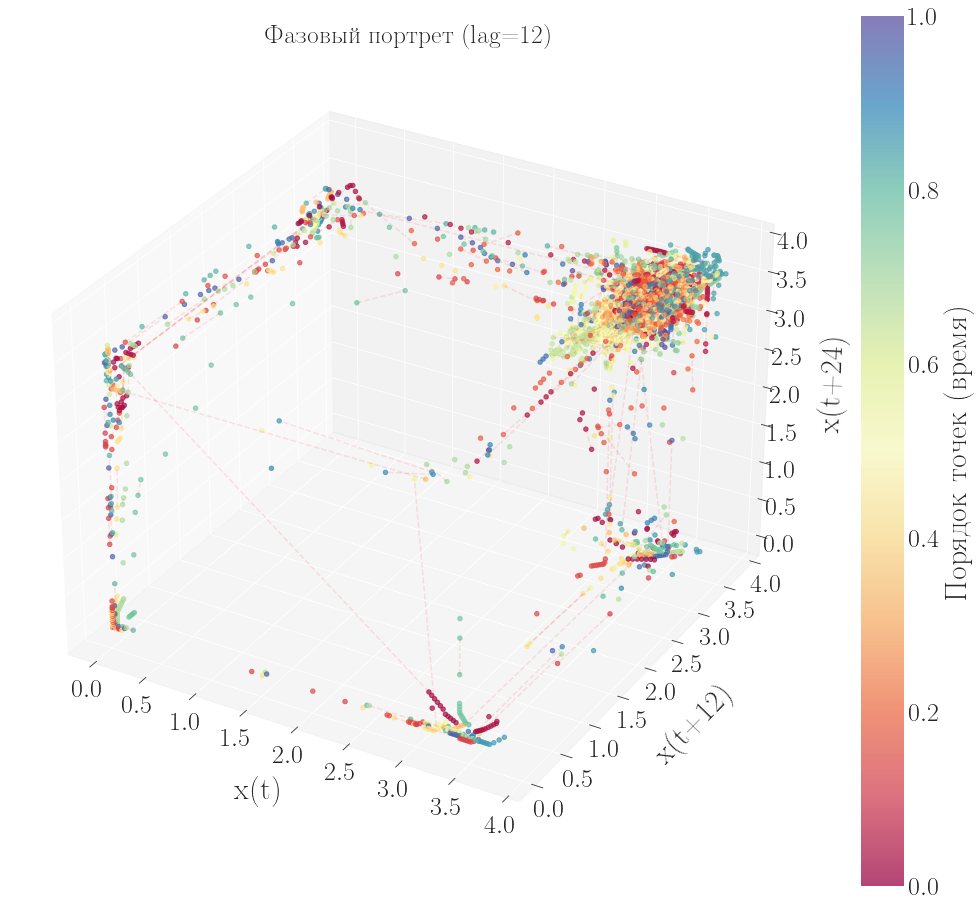

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

points = 5000
if len(embedded) < points:
    points = len(embedded)

x = embedded[:points, 0]
y = embedded[:points, 1]
z = embedded[:points, 2]

colors = np.linspace(0, 1, points)  

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=colors, alpha=0.7, s=20, cmap='Spectral')
for i in range(0, points, 5):
    ax.plot(x[i:i+2], y[i:i+2], z[i:i+2], 'r--', alpha = 0.1)
plt.colorbar(sc, label='Порядок точек (время)')
ax.set_title(f'Фазовый портрет (lag={lag})')
ax.set_xlabel('x(t)', labelpad=25)
ax.set_ylabel(f'x(t+{lag})', labelpad=25)
ax.set_zlabel(f'x(t+{2*lag})', labelpad=20)
fig.patch.set_facecolor('white')  
ax.set_facecolor('white') 
plt.show()


C:\Users\ilya\AppData\Local\Temp\ipykernel_18500\570955332.py:44: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(sc, label='Порядок точек (время)')


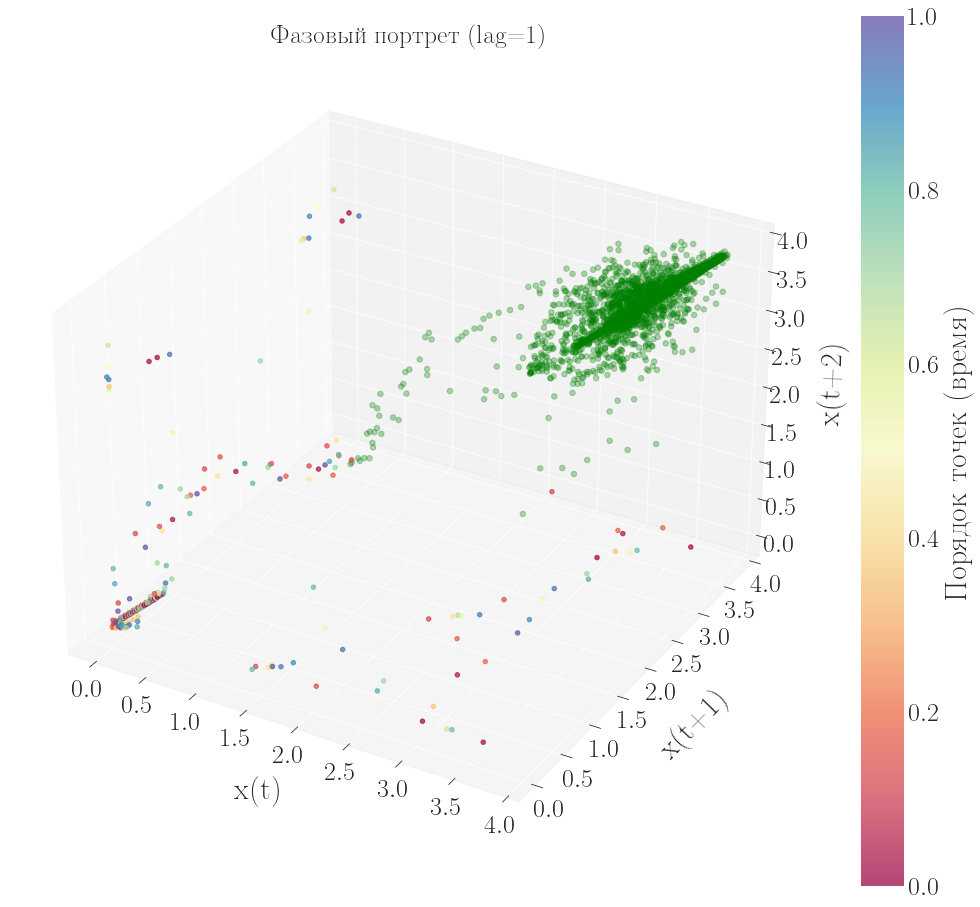

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

points = 5000
if len(embedded) < points:
    points = len(embedded)

x = embedded[:points, 0]
y = embedded[:points, 1]
z = embedded[:points, 2]

colors = np.linspace(0, 1, points)

threshold = 1.5  
mean_x = np.mean(x)
mean_y = np.mean(y)
mean_z = np.mean(z)

close_points = (np.abs(x - mean_x) < threshold) & (np.abs(y - mean_y) < threshold) & (np.abs(z - mean_z) < threshold)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x[close_points], y[close_points], z[close_points], c='green', alpha=0.3, s=30)

non_close_points = ~close_points  

ax.scatter(x[non_close_points], y[non_close_points], z[non_close_points], c=colors[non_close_points], alpha=0.7, s=20, cmap='Spectral')

plt.colorbar(sc, label='Порядок точек (время)')

ax.set_title(f'Фазовый портрет (lag={lag})')
ax.set_xlabel('x(t)', labelpad=25)
ax.set_ylabel(f'x(t+{lag})', labelpad=25)
ax.set_zlabel(f'x(t+{2*lag})', labelpad=20)
fig.patch.set_facecolor('white') 
ax.set_facecolor('white')  

plt.show()


In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def takens_embedding(series, dim, lag):
    n = len(series) - (dim-1)*lag
    return np.array([series[i:i+(dim-1)*lag+1:lag] for i in range(n)])

def correlation_dimension(embedded, epsilon_range):
    nbrs = NearestNeighbors(radius=epsilon_range).fit(embedded)
    distances, _ = nbrs.radius_neighbors(embedded)
    counts = [len(d) for d in distances]
    return np.log(counts).mean()

embedded_co2 = takens_embedding(co2_series, dim=3, lag=lags)
epsilons = np.linspace(0.1*co2_series.std(), co2_series.std(), 20)
dimensions = [correlation_dimension(embedded_co2, eps) for eps in epsilons]


### Интерпретация результатов

1. **Высокие значения корреляционной размерности**  
   Если размерность $ D_c \approx 8 $ достигает плато при увеличении $ \epsilon $, это может означать:
   - **Сильный шум**: Данные содержат значительную стохастическую составляющую, которая "маскирует" детерминированную динамику.
   - **Высокоразмерная система**: Процесс зависит от большого числа независимых переменных (например, работа ГТУ регулируется множеством параметров).
   - **Неоптимальные параметры реконструкции**: Некорректно выбранные `dim` (размерность вложения) или `lag` (лаг) искажают структуру фазового пространства.

2. **Поведение графика**  
   - **Логарифмический рост** на малых $ \epsilon $: Характерен для систем с фрактальной структурой.  
   - **Плато при $ D_c \approx 8 $**: Система ведет себя как высокоразмерная (близкая к случайному процессу) на больших масштабах.  

---



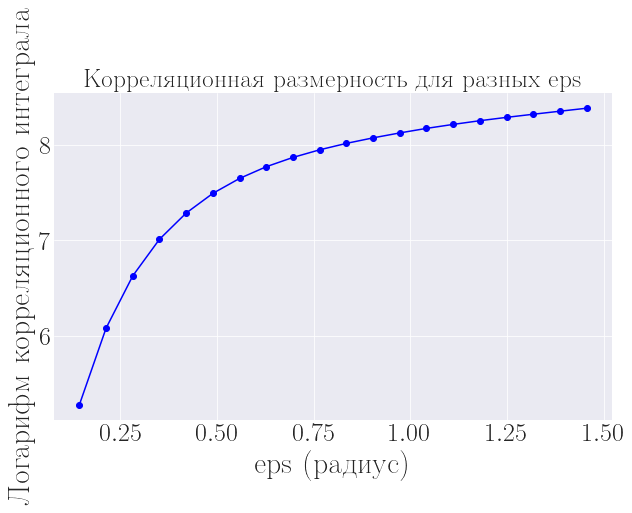

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epsilons, dimensions, 'bo-')
plt.title('Корреляционная размерность для разных eps')
plt.xlabel('eps (радиус)')
plt.ylabel('Логарифм корреляционного интеграла')
plt.grid(True)
plt.show()

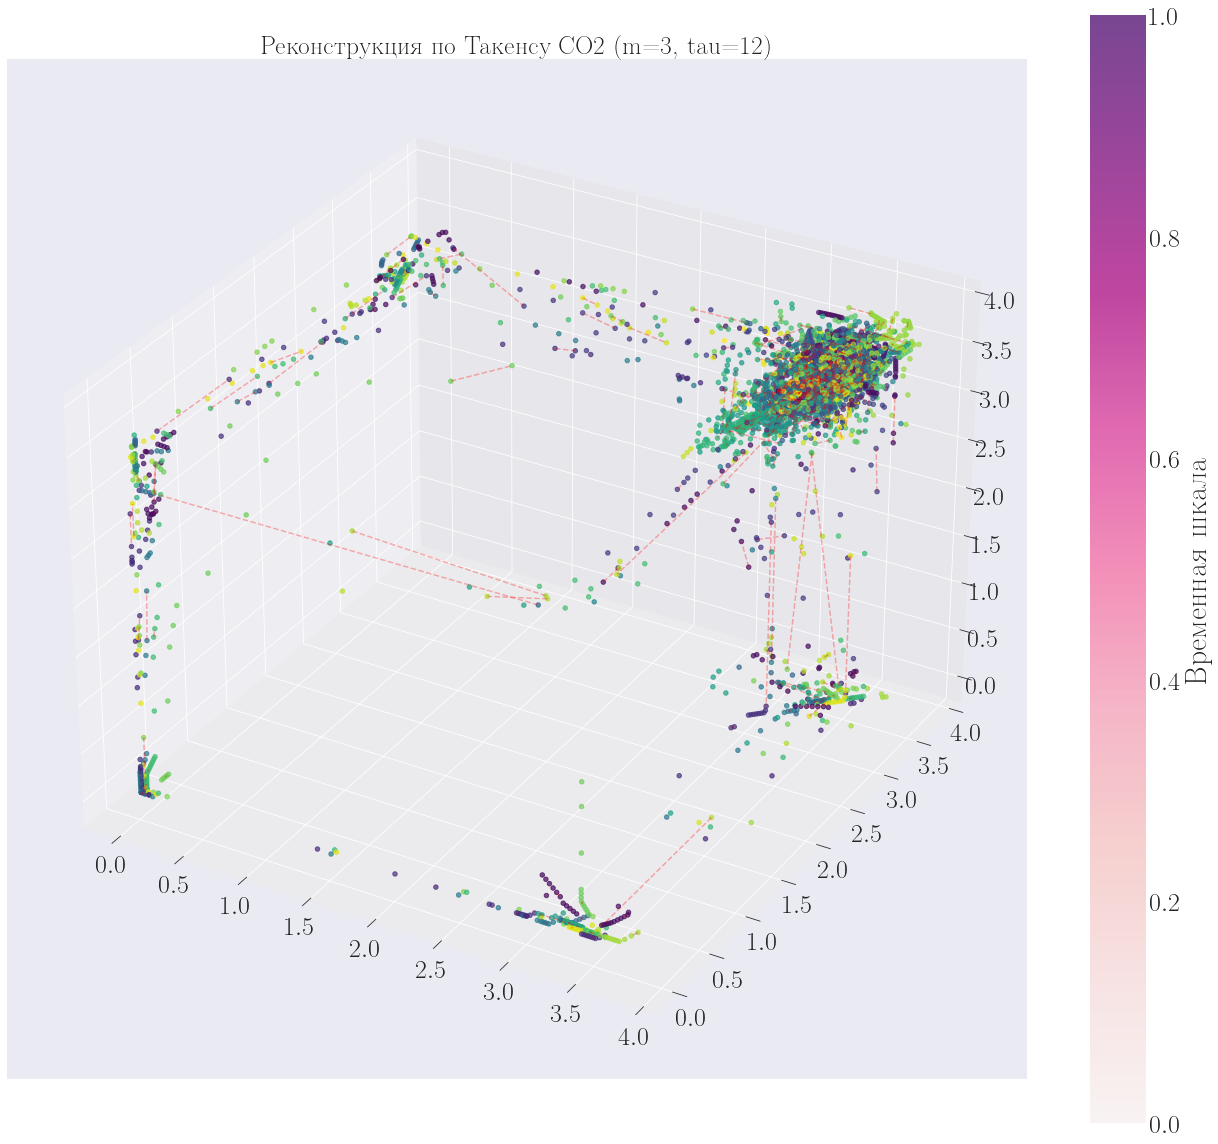

In [ ]:

fig = plt.figure(figsize=(18,16))
ax = fig.add_subplot(111, projection='3d')

colors1 = plt.cm.viridis(np.linspace(0,1,len(x)))

sc = ax.scatter(x, y, z, c=colors, alpha=0.7, s=20, cmap='viridis')
plt.colorbar(sc, label='Временная шкала')

for i in range(0, points, 10):
    ax.plot(x[i:i+2], y[i:i+2], z[i:i+2], 'r--', alpha = 0.3)

ax.set_title(f'В по Такенсу CO2 (m=3, tau={lags})')
plt.tight_layout()
plt.show()

#### Оценка наибольшего показателя Ляпунова

Интерпретация:
- lyap_exp > 0 - система хаотична
- lyap_exp ≈ 0 - периодическая динамика
- lyap_exp < 0 - система стремится к фиксированной точке

In [ ]:
co2_series = df_merge['CHTEC4_TTO.22789'].dropna()

In [ ]:
import numpy as np
from nolds import lyap_r

co2_clean = co2_series.dropna().astype(np.float64).values

try:
    lyap_exp = lyap_r(co2_clean, emb_dim=3, lag=lags)
    print(f"Наибольший показатель Ляпунова: {lyap_exp:.3f}")
except Exception as e:
    print(f"Ошибка в стандартном расчете: {e}")
    
    try:
        lyap_exp = lyap_r(co2_clean, 
                         emb_dim=3, 
                         lag=lags,
                         min_tsep=300,  
                         )  
        print(f"Успешный расчет с параметрами. Показатель Ляпунова: {lyap_exp:.3f}")
    except Exception as e:
        print(f"Не удалось вычислить: {e}")

Ошибка в стандартном расчете: ufunc 'ceil' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
Успешный расчет с параметрами. Показатель Ляпунова: 0.053
